# Capstone 2, Notebook 2
### Advanced Feature Tuning and Model Ready Data Creation

The ['Hot Hand Theory'](https://en.wikipedia.org/wiki/Hot_hand) might be the original piece of sports analytics work, and certainly the most discussed and disected. Here we propose a slightly different take, which is to apply financial methods of finding trends to identify values. While there is significant value in a players past overall performance, but being able to spot immediate trends creates a near term arbitrage opportunity where players are undervalued but on an upswing. 

The theory in this case is that since time on ice and time on the power play are the biggest indecators of success, rivaled only by posession metrics, if a model could detect an upward trend it could find undervalued players in advance and forecast postive events.

Worth noting is that these financial methods have also been heavily critiqued, perhaps most [notably by the legendary Burton Malkiel](https://www.forbes.com/sites/steveforbes/2019/04/29/podcast--burton-malkiel-the-man-who-claimed-monkeys-pick-better-stocks-is-vindicated/#6a23a44075d7), but where they fail in financial markets they could very well succeed in this use case. The most frequent critique of 'Chart watchers' and 'market timers' is that they are using prior information to fill in future assumptions, while the [efficient market theory states](https://www.investopedia.com/terms/e/efficientmarkethypothesis.asp) that there is far more current information that is readily available and therefore the market price at current time isn't based on past pricing. In this case, we do not have more current information or insight into why a player is seeing more time; they might have been moved due to injury or a trade. Even if we do have some of that information for some players via say Twitter or trade trackers, coverage isn't global and we don't have an efficient way to find out if a player will see an increase in ice time. Therefore, finding a moving average might well be an effective signal to show that a player's points will soon increase as well. 

Here our hypothesis is that if the average time, power play time, or possession metrics have increased across the past five games over the previous 20, the player will continue to both maintain that higher standing and, due to the nature of those metrics, also see an increase in over all points. In this next segment we'll do a quick feature generation and backtest.


This notebook outlines the generation of some advanced features intended to simulate data that could be used to simulate a forecast. The most difficult part of feature creation was figuring out how to 'append' the last games results and the various primary data. SQL has many built in functions so this made the most sense for this manipulation. Therefore, an instance was created to hold this data and create a sort of primary key to join on.

Notes on the following: you could use this to set up your own instance, but obviously it will fail if you run in the notebook here on github as the passwords and various drives are on a local machine not hosted here, so you'll have to imagine it. That said the flatfiles are saved on github so you could recreate the effort on a local machine with some modifiers.

Secondly, the comp_data here is from the files generated on the first notebook, but the upload was included here to keep all of the SQL work in one area.

In [2]:
import os
import pandas as pd
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine
from sqlalchemy import MetaData
from sqlalchemy import inspect
from sqlalchemy import Table
from sqlalchemy import Column, Integer, String


path = "~/Users/michaelwood/Documents/TheCheckingLines/Capstone2/.bash_profile"
databasename = os.environ.get('hockeydb_name')
user = os.environ.get('hockeydb_user')
pw = os.environ.get('hockeydb_pass')
host = os.environ.get('hockeydb_host')
port = os.environ.get('hockeydb_port')

postgres_db = {'drivername': 'postgres',
               'database':databasename,
               'username': user,
               'password': pw,
               'port': port}
engine = create_engine(URL(**postgres_db))

In [3]:
print(postgres_db)

{'drivername': 'postgres', 'database': 'hockeydb', 'username': 'michaelwood', 'password': None, 'port': '5432'}


In [ ]:
from pandas.io import sql

comp_data = pd.read_csv("combined_skater_files.csv.gz")
comp_data.to_sql(con=engine, name='player_by_game',if_exists='fail', chunksize=10000)
print('rows uploaded: ',engine.execute("SELECT count(*) FROM player_by_game").fetchone()[0])

The next segment is to create a partition to hold act as the key, and a few rows to check that the function worked

In [ ]:
engine.execute("alter table player_by_game drop column if exists game_order;")
engine.execute("ALTER TABLE player_by_game ADD COLUMN game_order INT;")
engine.execute("UPDATE player_by_game SET game_order = up.row_number FROM (SELECT player, game_id, ROW_NUMBER () OVER (PARTITION BY player ORDER BY game_date desc) as row_number FROM player_by_game) up where player_by_game.player||player_by_game.game_id = up.player||up.game_id;")

In [ ]:
engine.execute("select player, game_date, game_id,game_order  from player_by_game where lastname = 'GREER' order by game_id desc;").fetchall()[0:5]

In [6]:
playerbg = pd.read_sql(sql = "select * from player_by_game;",con = engine)

In [7]:
playerbg.head()

,index,player,game_id,game_date,season_comp,Team_comp,Opponent_comp,is_home_comp,TOI_comp,G_comp,...,skater_pptoi_percentage,skater_shtoi_percentage,points_per_60,iFF_per_60,ixG_per_60,position,position_type,firstname,lastname,game_order
0,441584,ZENON.KONOPKA,2013021047,2014-03-20,20132014,BUF,EDM,0,5.916667,0,...,0.021212,0.274242,0.0,10.140845,0.000052,C,F,ZENON,KONOPKA,2
1,2,A.J..GREER,2016020268,2016-11-19,20162017,COL,MIN,0,12.700000,0,...,0.000000,0.120301,0.0,4.724409,0.000089,L,F,AJ,GREER,35
2,3,A.J..GREER,2016020278,2016-11-21,20162017,COL,CBJ,0,15.433333,0,...,0.000000,0.000000,0.0,16.021598,0.610197,L,F,AJ,GREER,34
3,4,A.J..GREER,2016020296,2016-11-23,20162017,COL,EDM,1,11.850000,0,...,0.216667,0.054104,0.0,0.000000,0.000000,L,F,AJ,GREER,33
4,5,A.J..GREER,2017020134,2017-10-24,20172018,COL,DAL,1,8.366667,0,...,0.014599,0.000000,0.0,14.342629,1.582916,L,F,A.J.,GREER,32


In [8]:
playerbg.describe()

,index,game_id,season_comp,is_home_comp,TOI_comp,G_comp,A1_comp,A2_comp,Points_comp,iSF_comp,...,t_xGA_state_sh,hat_trick,dk_points,skater_toi_percentage,skater_pptoi_percentage,skater_shtoi_percentage,points_per_60,iFF_per_60,ixG_per_60,game_order
count,441586.000000,4.415860e+05,4.415860e+05,441586.000000,441586.000000,441586.000000,441586.000000,441586.0,441586.000000,441586.000000,...,441586.000000,441586.000000,441586.000000,441586.000000,4.415860e+05,441586.000000,441586.000000,441586.000000,441586.000000,441586.000000
mean,220792.500000,2.012948e+09,2.013128e+07,0.500009,16.519313,0.153035,0.143625,0.0,0.296660,1.684920,...,0.145823,0.001470,1.994554,0.271024,inf,0.216612,1.081981,8.659403,0.734628,216.597315
std,127475.042322,3.235985e+06,3.236342e+04,0.500001,5.033229,0.405322,0.389025,0.0,0.574845,1.547779,...,0.328051,0.038309,1.958460,0.081900,NaN,0.227986,2.171429,6.919072,1.242200,180.495759
min,0.000000,2.008020e+09,2.008201e+07,0.000000,0.016667,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000278,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,110396.250000,2.010021e+09,2.010201e+07,0.000000,13.250000,0.000000,0.000000,0.0,0.000000,1.000000,...,0.000000,0.000000,0.500000,0.218056,0.000000e+00,0.000000,0.000000,3.596404,0.000000,69.000000
50%,220792.500000,2.013021e+09,2.013201e+07,1.000000,16.683333,0.000000,0.000000,0.0,0.000000,1.000000,...,0.000000,0.000000,1.500000,0.274613,1.809330e-01,0.163214,0.000000,7.555089,0.170099,169.000000
75%,331188.750000,2.016020e+09,2.016202e+07,1.000000,19.900000,0.000000,0.000000,0.0,0.000000,3.000000,...,0.039080,0.000000,3.000000,0.326667,4.912203e-01,0.391236,0.000000,12.550702,0.938550,325.000000
max,441585.000000,2.018030e+09,2.018202e+07,1.000000,41.866667,5.000000,5.000000,0.0,7.000000,14.000000,...,3.599245,1.000000,22.500000,0.609444,inf,1.000000,72.000000,213.500000,37.258950,934.000000


Multiple moving averages and rate changes were created to have values that can be used to generate forecasts.

In [9]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [10]:
## here I'm checking that the new column value would work as assumed
rolled_values = playerbg.sort_values(by=['player','game_order'],ascending=True).groupby('player')['dk_points'].rolling(2).mean().reset_index()
rolled_values[0:4]

,player,level_1,dk_points
0,A.J..GREER,35,NaN
1,A.J..GREER,34,1.00
2,A.J..GREER,33,2.50
3,A.J..GREER,32,1.75


In [11]:
type(playerbg)

pandas.core.frame.DataFrame

In [12]:
## setting the index so I can join back to the first table
playerbg.set_index(["player",'game_id',"game_order"], inplace=True) 
playerbg.head()

index  game_date  season_comp Team_comp  \
player        game_id    game_order                                             
ZENON.KONOPKA 2013021047 2           441584 2014-03-20     20132014       BUF   
A.J..GREER    2016020268 35               2 2016-11-19     20162017       COL   
              2016020278 34               3 2016-11-21     20162017       COL   
              2016020296 33               4 2016-11-23     20162017       COL   
              2017020134 32               5 2017-10-24     20172018       COL   

                                    Opponent_comp  is_home_comp   TOI_comp  \
player        game_id    game_order                                          
ZENON.KONOPKA 2013021047 2                    EDM             0   5.916667   
A.J..GREER    2016020268 35                   MIN             0  12.700000   
              2016020278 34                   CBJ             0  15.433333   
              2016020296 33                   EDM             1  11.850000   
              2017020134 32                   DAL             1   8.366667   

                                     G_comp  A1_comp  A2_comp  ...  \
player        game_id    game_order                            ...   
ZENON.KONOPKA 2013021047 2                0        0        0  ...   
A.J..GREER    2016020268 35               0        0        0  ...   
              2016020278 34               0        0        0  ...   
              2016020296 33               0        0        0  ...   
              2017020134 32               0        0        0  ...   

                                     skater_toi_percentage  \
player        game_id    game_order                          
ZENON.KONOPKA 2013021047 2                        0.098611   
A.J..GREER    2016020268 35                       0.211667   
              2016020278 34                       0.249663   
              2016020296 33                       0.197500   
              2017020134 32                       0.139444   

                                     skater_pptoi_percentage  \
player        game_id    game_order                            
ZENON.KONOPKA 2013021047 2                          0.021212   
A.J..GREER    2016020268 35                         0.000000   
              2016020278 34                         0.000000   
              2016020296 33                         0.216667   
              2017020134 32                         0.014599   

                                     skater_shtoi_percentage  points_per_60  \
player        game_id    game_order                                           
ZENON.KONOPKA 2013021047 2                          0.274242            0.0   
A.J..GREER    2016020268 35                         0.120301            0.0   
              2016020278 34                         0.000000            0.0   
              2016020296 33                         0.054104            0.0   
              2017020134 32                         0.000000            0.0   

                                     iFF_per_60  ixG_per_60  position  \
player        game_id    game_order                                     
ZENON.KONOPKA 2013021047 2            10.140845    0.000052         C   
A.J..GREER    2016020268 35            4.724409    0.000089         L   
              2016020278 34           16.021598    0.610197         L   
              2016020296 33            0.000000    0.000000         L   
              2017020134 32           14.342629    1.582916         L   

                                     position_type  firstname  lastname  
player        game_id    game_order                                      
ZENON.KONOPKA 2013021047 2                       F      ZENON   KONOPKA  
A.J..GREER    2016020268 35                      F         AJ     GREER  
              2016020278 34                      F         AJ     GREER  
              2016020296 33                      F         AJ     GREER  
              2017020134 32           

In [13]:
player_avgs_base = playerbg[["TOI_comp", "G_comp" , "Points_comp" , "iSF_comp",  "iFF_comp" , "iCF_comp","ixG_comp","iBLK_comp","iHF","OZS_comp","TOI_ev", "G_ev","Points_ev","iSF_ev","iFF_ev","iCF_ev","ixG_ev","iBLK_ev","onGF","onFF","onCF","onxGF","onFA_state","TOI","G","Points" , "iSF" , "iFF", "iCF" ,"ixG","onGF_pp","onSF_pp",  "onFF_pp" , "onCF_pp" , "onxGF_pp" ,"TOI_sh","G_sh","Points_sh","iSF_sh","iFF_sh","iCF_sh","ixG_sh","onGF_sh" ,"onSF_sh" ,"onFF_sh" , "onCF_sh" , "onxGF_sh" ,   "onxGA_sh" , "hat_trick" , "dk_points" , "skater_toi_percentage" , "skater_pptoi_percentage", "skater_shtoi_percentage", "points_per_60","iFF_per_60","ixG_per_60"]]

In [14]:
## this is simply sorting all the varaibles
player_avgs_base.reset_index(level=["game_id"],inplace=True)

player_avgs_base.sort_index(level=["player","game_order"],ascending=False, inplace=True)

player_avgs_base

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


game_id  TOI_comp  G_comp  Points_comp  iSF_comp  \
player        game_order                                                        
ZENON.KONOPKA 301         2008020405  0.783333       0            0         0   
              300         2008020416  5.266667       0            0         0   
              299         2008020433  3.366667       0            0         0   
              298         2008021168  7.700000       0            0         1   
              297         2008021190  9.966667       0            0         2   
...                              ...       ...     ...          ...       ...   
A.J..GREER    5           2018020894  6.766667       0            0         0   
              4           2018020913  4.000000       0            0         0   
              3           2018020926  7.116667       1            1         1   
              2           2018020942  5.216667       0            0         2   
              1           2018020951  7.816667       0            0         1   

                          iFF_comp  iCF_comp  ixG_comp  iBLK_comp  iHF  ...  \
player        game_order                                                ...   
ZENON.KONOPKA 301                0         0  0.000000          0    0  ...   
              300                0         1  0.000000          0    2  ...   
              299                0         0  0.000000          0    1  ...   
              298                1         1  0.000000          0    1  ...   
              297                2         2  0.000000          0    0  ...   
...                            ...       ...       ...        ...  ...  ...   
A.J..GREER    5                  0         0  0.000000          0    1  ...   
              4                  0         0  0.000000          0    0  ...   
              3                  1         1  0.107321          0    1  ...   
              2                  2         3  0.015250          1    3  ...   
              1                  1         1  0.089531          0    0  ...   

                          onxGF_sh  onxGA_sh  hat_trick  dk_points  \
player        game_order                                             
ZENON.KONOPKA 301              0.0       0.0        0.0        0.0   
              300              0.0       0.0        0.0        0.0   
              299              0.0       0.0        0.0        0.0   
              298              0.0       0.0        0.0        0.5   
              297              0.0       0.0        0.0        1.0   
...                            ...       ...        ...        ...   
A.J..GREER    5                0.0       0.0        0.0        0.0   
              4                0.0       0.0        0.0        0.0   
              3                0.0       0.0        0.0        3.5   
              2                0.0       0.0        0.0        1.5   
              1                0.0       0.0        0.0        0.5   

                          skater_toi_percentage  skater_pptoi_percentage  \
player        game_order                                                   
ZENON.KONOPKA 301                      0.013056                 0.009107   
              300                      0.087778                 0.000000   
              299                      0.056111                 0.000000   
              298                      0.128333                 0.000000   
              297                      0.166111                 0.004992   
...                                         ...                      ...   
A.J..GREER    5                        0.112778                 0.000000   
              4                        0.066667                 0.000000   
              3                        0.118611                 0.000000   
              2                        0.086944                 0.000000   
              1                        0.130278                 0.000000   

                          skater_shtoi_percenta

In [15]:
for col in player_avgs_base.columns:
    player_avgs_base[col+'_avg_lt'] = player_avgs_base.groupby('player')[col].apply(lambda ser: ser.rolling(2).mean().shift().reset_index(level=0, drop=True))
    #player_avgs_base.groupby('player').apply(lambda _df: _df.sort_values(by=['game_order'], ascending=False)[col].rolling(2).mean().shift().reset_index(level=0, drop=True))
    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
player_avgs_base2 = playerbg[["TOI_comp", "G_comp" , "Points_comp" , "iSF_comp",  "iFF_comp" , "iCF_comp","ixG_comp","iBLK_comp","iHF","OZS_comp","TOI_ev", "G_ev","Points_ev","iSF_ev","iFF_ev","iCF_ev","ixG_ev","iBLK_ev","onGF","onFF","onCF","onxGF","onFA_state","TOI","G","Points" , "iSF" , "iFF", "iCF" ,"ixG","onGF_pp","onSF_pp",  "onFF_pp" , "onCF_pp" , "onxGF_pp" ,"TOI_sh","G_sh","Points_sh","iSF_sh","iFF_sh","iCF_sh","ixG_sh","onGF_sh" ,"onSF_sh" ,"onFF_sh" , "onCF_sh" , "onxGF_sh" ,   "onxGA_sh" , "hat_trick" , "dk_points" , "skater_toi_percentage" , "skater_pptoi_percentage", "skater_shtoi_percentage", "points_per_60","iFF_per_60","ixG_per_60"]]
## this is simply sorting all the varaibles
player_avgs_base2.reset_index(level=["game_id"],inplace=True)

player_avgs_base2.sort_index(level=["player","game_order"],ascending=False, inplace=True)

for col in player_avgs_base2.columns:
    player_avgs_base2[col+'_avg_lf'] = player_avgs_base2.groupby('player')[col].apply(lambda ser: ser.rolling(5).mean().shift().reset_index(level=0, drop=True))
    


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
player_avgs_base3 = playerbg[["TOI_comp", "G_comp" , "Points_comp" , "iSF_comp",  "iFF_comp" , "iCF_comp","ixG_comp","iBLK_comp","iHF","OZS_comp","TOI_ev", "G_ev","Points_ev","iSF_ev","iFF_ev","iCF_ev","ixG_ev","iBLK_ev","onGF","onFF","onCF","onxGF","onFA_state","TOI","G","Points" , "iSF" , "iFF", "iCF" ,"ixG","onGF_pp","onSF_pp",  "onFF_pp" , "onCF_pp" , "onxGF_pp" ,"TOI_sh","G_sh","Points_sh","iSF_sh","iFF_sh","iCF_sh","ixG_sh","onGF_sh" ,"onSF_sh" ,"onFF_sh" , "onCF_sh" , "onxGF_sh" ,   "onxGA_sh" , "hat_trick" , "dk_points" , "skater_toi_percentage" , "skater_pptoi_percentage", "skater_shtoi_percentage", "points_per_60","iFF_per_60","ixG_per_60"]]
## this is simply sorting all the varaibles
player_avgs_base3.reset_index(level=["game_id"],inplace=True)

player_avgs_base3.sort_index(level=["player","game_order"],ascending=False, inplace=True)

for col in player_avgs_base3.columns:
    player_avgs_base3[col+'_avg_lten'] = player_avgs_base3.groupby('player')[col].apply(lambda ser: ser.rolling(10).mean().shift().reset_index(level=0, drop=True))
    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
player_avgs_base4 = playerbg[["TOI_comp", "G_comp" , "Points_comp" , "iSF_comp",  "iFF_comp" , "iCF_comp","ixG_comp","iBLK_comp","iHF","OZS_comp","TOI_ev", "G_ev","Points_ev","iSF_ev","iFF_ev","iCF_ev","ixG_ev","iBLK_ev","onGF","onFF","onCF","onxGF","onFA_state","TOI","G","Points" , "iSF" , "iFF", "iCF" ,"ixG","onGF_pp","onSF_pp",  "onFF_pp" , "onCF_pp" , "onxGF_pp" ,"TOI_sh","G_sh","Points_sh","iSF_sh","iFF_sh","iCF_sh","ixG_sh","onGF_sh" ,"onSF_sh" ,"onFF_sh" , "onCF_sh" , "onxGF_sh" ,   "onxGA_sh" , "hat_trick" , "dk_points" , "skater_toi_percentage" , "skater_pptoi_percentage", "skater_shtoi_percentage", "points_per_60","iFF_per_60","ixG_per_60"]]
## this is simply sorting all the varaibles
player_avgs_base4.reset_index(level=["game_id"],inplace=True)

player_avgs_base4.sort_index(level=["player","game_order"],ascending=False, inplace=True)

for col in player_avgs_base4.columns:
    player_avgs_base4[col+'_avg_ltwen'] = player_avgs_base4.groupby('player')[col].apply(lambda ser: ser.rolling(20).mean().shift().reset_index(level=0, drop=True))
    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In the following we're checking to see that the rolling functions worked to produce at the expected levels.

In [19]:
player_avgs_base2.head(10)

game_id   TOI_comp  G_comp  Points_comp  \
player        game_order                                               
ZENON.KONOPKA 301         2008020405   0.783333       0            0   
              300         2008020416   5.266667       0            0   
              299         2008020433   3.366667       0            0   
              298         2008021168   7.700000       0            0   
              297         2008021190   9.966667       0            0   
              296         2008021205  12.900000       0            1   
              295         2008021222   9.083333       0            0   
              294         2009020016   6.283333       0            0   
              293         2009020028   5.383333       0            0   
              292         2009020040   9.433333       0            0   

                          iSF_comp  iFF_comp  iCF_comp  ixG_comp  iBLK_comp  \
player        game_order                                                      
ZENON.KONOPKA 301                0         0         0       0.0          0   
              300                0         0         1       0.0          0   
              299                0         0         0       0.0          0   
              298                1         1         1       0.0          0   
              297                2         2         2       0.0          0   
              296                2         2         2       0.0          0   
              295                1         1         1       0.0          2   
              294                2         2         2       0.0          1   
              293                0         0         0       0.0          0   
              292                2         3         3       0.0          1   

                          iHF  ...  onxGF_sh_avg_lf  onxGA_sh_avg_lf  \
player        game_order       ...                                     
ZENON.KONOPKA 301           0  ...              NaN              NaN   
              300           2  ...              NaN              NaN   
              299           1  ...              NaN              NaN   
              298           1  ...              NaN              NaN   
              297           0  ...              NaN              NaN   
              296           1  ...              0.0              0.0   
              295           1  ...              0.0              0.0   
              294           1  ...              0.0              0.0   
              293           3  ...              0.0              0.0   
              292           1  ...              0.0              0.0   

                          hat_trick_avg_lf  dk_points_avg_lf  \
player        game_order                                       
ZENON.KONOPKA 301                      NaN               NaN   
              300                      NaN               NaN   
              299                      NaN               NaN   
              298                      NaN               NaN   
              297                      NaN               NaN   
              296                      0.0               0.3   
              295                      0.0               0.9   
              294                      0.0               1.2   
              293                      0.0               1.5   
              292                      0.0               1.4   

                          skater_toi_percentage_avg_lf  \
player        game_order                                 
ZENON.KONOPKA 301                                  NaN   
              300                                  NaN   
              299                                  NaN   
              298                                  NaN   
              297                                  NaN   
              296                             0.090278   
              295                             0.130667   
              294                             0.143389   
 

In [20]:
player_avgs_base3.head(30)[7:13]

game_id  TOI_comp  G_comp  Points_comp  iSF_comp  \
player        game_order                                                        
ZENON.KONOPKA 294         2009020016  6.283333       0            0         2   
              293         2009020028  5.383333       0            0         0   
              292         2009020040  9.433333       0            0         2   
              291         2009020055  6.333333       0            0         0   
              290         2009020069  9.566667       0            0         1   
              289         2009020083  8.500000       0            0         0   

                          iFF_comp  iCF_comp  ixG_comp  iBLK_comp  iHF  ...  \
player        game_order                                                ...   
ZENON.KONOPKA 294                2         2       0.0          1    1  ...   
              293                0         0       0.0          0    3  ...   
              292                3         3       0.0          1    1  ...   
              291                0         0       0.0          1    1  ...   
              290                1         2       0.0          0    2  ...   
              289                0         0       0.0          0    5  ...   

                          onxGF_sh_avg_lten  onxGA_sh_avg_lten  \
player        game_order                                         
ZENON.KONOPKA 294                       NaN                NaN   
              293                       NaN                NaN   
              292                       NaN                NaN   
              291                       0.0                0.0   
              290                       0.0                0.0   
              289                       0.0                0.0   

                          hat_trick_avg_lten  dk_points_avg_lten  \
player        game_order                                           
ZENON.KONOPKA 294                        NaN                 NaN   
              293                        NaN                 NaN   
              292                        NaN                 NaN   
              291                        0.0                0.90   
              290                        0.0                0.95   
              289                        0.0                1.00   

                          skater_toi_percentage_avg_lten  \
player        game_order                                   
ZENON.KONOPKA 294                                    NaN   
              293                                    NaN   
              292                                    NaN   
              291                               0.115045   
              290                               0.124295   
              289                               0.131462   

                          skater_pptoi_percentage_avg_lten  \
player        game_order                                     
ZENON.KONOPKA 294                                      NaN   
              293                                      NaN   
              292                                      NaN   
              291                                 0.001410   
              290                                 0.000499   
              289                                 0.000499   

                          skater_shtoi_percentage_avg_lten  \
player        game_order                                     
ZENON.KONOPKA 294                                      NaN   
              293                                      NaN   
              292                                      NaN   
              291                                 0.002999   
              290                                 0.002999   
              289                                 0.002999   

                          points_per_60_avg_lten  iFF_per_60_avg_lten  \
player        game_order                                                
ZENON.KONOPKA 294                            NaN    

In [21]:
player_avgs_base4.head(30)[17:23]

game_id   TOI_comp  G_comp  Points_comp  \
player        game_order                                               
ZENON.KONOPKA 284         2009020183  11.066667       0            0   
              283         2009020196   9.666667       0            0   
              282         2009020199   4.866667       0            0   
              281         2009020211   8.850000       0            0   
              280         2009020228   8.966667       0            0   
              279         2009020257   7.283333       0            0   

                          iSF_comp  iFF_comp  iCF_comp  ixG_comp  iBLK_comp  \
player        game_order                                                      
ZENON.KONOPKA 284                0         1         1       0.0          0   
              283                1         1         1       0.0          1   
              282                0         0         0       0.0          0   
              281                0         0         0       0.0          2   
              280                1         1         1       0.0          1   
              279                1         1         1       0.0          0   

                          iHF  ...  onxGF_sh_avg_ltwen  onxGA_sh_avg_ltwen  \
player        game_order       ...                                           
ZENON.KONOPKA 284           3  ...                 NaN                 NaN   
              283           2  ...                 NaN                 NaN   
              282           1  ...                 NaN                 NaN   
              281           1  ...                 0.0                 0.0   
              280           1  ...                 0.0                 0.0   
              279           1  ...                 0.0                 0.0   

                          hat_trick_avg_ltwen  dk_points_avg_ltwen  \
player        game_order                                             
ZENON.KONOPKA 284                         NaN                  NaN   
              283                         NaN                  NaN   
              282                         NaN                  NaN   
              281                         0.0                 0.60   
              280                         0.0                 0.65   
              279                         0.0                 0.70   

                          skater_toi_percentage_avg_ltwen  \
player        game_order                                    
ZENON.KONOPKA 284                                     NaN   
              283                                     NaN   
              282                                     NaN   
              281                                0.125286   
              280                                0.131517   
              279                                0.134600   

                          skater_pptoi_percentage_avg_ltwen  \
player        game_order                                      
ZENON.KONOPKA 284                                       NaN   
              283                                       NaN   
              282                                       NaN   
              281                                  0.008085   
              280                                  0.007629   
              279                                  0.007629   

                          skater_shtoi_percentage_avg_ltwen  \
player        game_order                                      
ZENON.KONOPKA 284                                       NaN   
              283                                       NaN   
              282                                       NaN   
              281                                  0.002702   
              280                                  0.002702   
              279                                  0.002702   

                          points_per_60_avg_ltwen  iFF_per_60_avg_ltwen  \
player        game_order                                   

The following columns were generated to show change over time, the thinking being that this might show a trend which would be valuable, particularly if the player were seeing an increase in ice time or shots. Additionally the standard deviation and aggregate column merging standard deviation and multiplying them in order to find positive trend lines. 

In [22]:
player_rolling_avgbs_base = playerbg[["TOI_comp", "G_comp" , "Points_comp" , "iFF_comp" , "iCF_comp","ixG_comp","TOI_ev", "G_ev","Points_ev","iFF_ev","iCF_ev","ixG_ev","onGF","onFF","onCF","onxGF","TOI","G","Points" , "iSF" , "iFF", "iCF" ,"ixG","onGF_pp", "onFF_pp" , "onCF_pp" , "onxGF_pp" ,  "dk_points" , "skater_toi_percentage" , "skater_pptoi_percentage", "skater_shtoi_percentage", "points_per_60","iFF_per_60","ixG_per_60"]]
player_rolling_avgbs_base.reset_index(level=["game_id"],inplace=True)
player_rolling_avgbs_base.sort_index(level=["player","game_order"],ascending=False, inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
for col in player_rolling_avgbs_base.columns:
    player_rolling_avgbs_base[col+'_lag'] = player_rolling_avgbs_base.groupby('player')[col].apply(lambda ser: ser.diff().reset_index(level=0, drop=True))
  

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [24]:
player_rolling_avgbs_base[0:2]

game_id  TOI_comp  G_comp  Points_comp  iFF_comp  \
player        game_order                                                        
ZENON.KONOPKA 301         2008020405  0.783333       0            0         0   
              300         2008020416  5.266667       0            0         0   

                          iCF_comp  ixG_comp    TOI_ev  G_ev  Points_ev  ...  \
player        game_order                                                 ...   
ZENON.KONOPKA 301                0       0.0  0.700000   0.0        0.0  ...   
              300                1       0.0  5.266667   0.0        0.0  ...   

                          onFF_pp_lag  onCF_pp_lag  onxGF_pp_lag  \
player        game_order                                           
ZENON.KONOPKA 301                 NaN          NaN           NaN   
              300                 0.0          0.0           0.0   

                          dk_points_lag  skater_toi_percentage_lag  \
player        game_order                                             
ZENON.KONOPKA 301                   NaN                        NaN   
              300                   0.0                   0.074722   

                          skater_pptoi_percentage_lag  \
player        game_order                                
ZENON.KONOPKA 301                                 NaN   
              300                           -0.009107   

                          skater_shtoi_percentage_lag  points_per_60_lag  \
player        game_order                                                   
ZENON.KONOPKA 301                                 NaN                NaN   
              300                                 0.0                0.0   

                          iFF_per_60_lag  ixG_per_60_lag  
player        game_order                                  
ZENON.KONOPKA 301                    NaN             NaN  
              300                    0.0             0.0  

[2 rows x 70 columns]

There was some assumed value both in knowing the sum  total of the movement, as well as standard deviation. Then an aggregate column was created that was intened to show where trend lines might exist. Additionally a method from finance was borrowed; breakout values, which were intended to show where a trendline was shifting in a positive direction, or in financial terms, set to 'break out' of the moving average. 

In [25]:

lag_cols = [col for col in player_rolling_avgbs_base.columns if 'lag' in col]

for col in lag_cols:
    player_rolling_avgbs_base[col+'_astt_std'] = player_rolling_avgbs_base.groupby('player')[col].apply(lambda ser: ser.fillna(0).rolling(2).std().shift)
    player_rolling_avgbs_base[col+'_astf_std'] = player_rolling_avgbs_base.groupby('player')[col].apply(lambda ser: ser.fillna(0).rolling(5).std().shift)
    player_rolling_avgbs_base[col+'_astten_std'] = player_rolling_avgbs_base.groupby('player')[col].apply(lambda ser: ser.fillna(0).rolling(10).std().shift)
    player_rolling_avgbs_base[col+'_asttwen_std'] = player_rolling_avgbs_base.groupby('player')[col].apply(lambda ser: ser.fillna(0).rolling(20).std().shift)
    player_rolling_avgbs_base[col+'_lastt'] = player_rolling_avgbs_base.groupby('player')[col].apply(lambda ser: ser.fillna(0).rolling(2).sum().shift)
    player_rolling_avgbs_base[col+'_lastf'] = player_rolling_avgbs_base.groupby('player')[col].apply(lambda ser: ser.fillna(0).rolling(5).sum().shift)
    player_rolling_avgbs_base[col+'_lastten'] = player_rolling_avgbs_base.groupby('player')[col].apply(lambda ser: ser.fillna(0).rolling(10).sum().shift)
    player_rolling_avgbs_base[col+'_lasttwen'] = player_rolling_avgbs_base.groupby('player')[col].apply(lambda ser: ser.fillna(0).rolling(20).sum().shift)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

Market theorists have proposed the idea of a 'dual moving average crossover' or a ['moving average convergence'](https://www.investopedia.com/terms/m/movingaverage.asp#examples-of-moving-average-indicators); this is a lagging indicator that shows upward momentum, where if the shorter average is above the value of the larger moving average, this is a positive trend signal and a time to 'buy' or select such a player. 

In order to limit noise, these metrics were created for time on ice, power play time on ice, Fenwick, and over all draftkings points, and then back tested before being added to the over all package. Credit for the base code and the visual here go to this excellent DataCamp tutorial, ['Python For Finance: Algorithmic Trading'](https://www.datacamp.com/community/tutorials/finance-python-trading).

In [26]:
# Initialize the short and long windows
short_window = 5
long_window = 20

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=player_rolling_avgbs_base.index)
signals['toi_signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = player_rolling_avgbs_base.groupby('player')['TOI_comp'].apply(lambda ser: ser.rolling(window=short_window, min_periods=1, center=False).mean().shift().reset_index(level=0, drop=True))

# Create long simple moving average over the long window
signals['long_mavg'] = player_rolling_avgbs_base.groupby('player')['TOI_comp'].apply(lambda ser: ser.rolling(window=long_window, min_periods=1, center=False).mean().shift().reset_index(level=0, drop=True))

# Create signals
signals['toi_signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['toi_signal'].diff()

# Print `signals`
print(signals[0:20])

                          toi_signal  short_mavg  long_mavg  positions
player        game_order                                              
ZENON.KONOPKA 301                0.0         NaN        NaN        NaN
              300                0.0    0.783333   0.783333        0.0
              299                0.0    3.025000   3.025000        0.0
              298                0.0    3.138889   3.138889        0.0
              297                0.0    4.279167   4.279167        0.0
              296                0.0    5.416667   5.416667        0.0
              295                1.0    7.840000   6.663889        1.0
              294                1.0    8.603333   7.009524        0.0
              293                1.0    9.186667   6.918750        0.0
              292                1.0    8.723333   6.748148        0.0
              291                1.0    8.616667   7.016667        0.0
              290                1.0    7.303333   6.954545        0.0
      

In [27]:
pd.set_option('display.max_columns', 800)
player_rolling_avgbs_base.head(10)

game_id   TOI_comp  G_comp  Points_comp  \
player        game_order                                               
ZENON.KONOPKA 301         2008020405   0.783333       0            0   
              300         2008020416   5.266667       0            0   
              299         2008020433   3.366667       0            0   
              298         2008021168   7.700000       0            0   
              297         2008021190   9.966667       0            0   
              296         2008021205  12.900000       0            1   
              295         2008021222   9.083333       0            0   
              294         2009020016   6.283333       0            0   
              293         2009020028   5.383333       0            0   
              292         2009020040   9.433333       0            0   

                          iFF_comp  iCF_comp  ixG_comp     TOI_ev  G_ev  \
player        game_order                                                  
ZENON.KONOPKA 301                0         0       0.0   0.700000   0.0   
              300                0         1       0.0   5.266667   0.0   
              299                0         0       0.0   3.366667   0.0   
              298                1         1       0.0   7.700000   0.0   
              297                2         2       0.0   9.916667   0.0   
              296                2         2       0.0  12.866667   0.0   
              295                1         1       0.0   8.283333   0.0   
              294                2         2       0.0   6.283333   0.0   
              293                0         0       0.0   5.383333   0.0   
              292                3         3       0.0   9.350000   0.0   

                          Points_ev  iFF_ev  iCF_ev  ixG_ev  onGF  onFF  onCF  \
player        game_order                                                        
ZENON.KONOPKA 301               0.0     0.0     0.0     0.0   0.0   1.0   1.0   
              300               0.0     0.0     1.0     0.0   0.0   4.0   7.0   
              299               0.0     0.0     0.0     0.0   0.0   3.0   5.0   
              298               0.0     1.0     1.0     0.0   0.0   3.0   4.0   
              297               0.0     2.0     2.0     0.0   0.0   4.0   6.0   
              296               1.0     2.0     2.0     0.0   1.0   7.0   8.0   
              295               0.0     1.0     1.0     0.0   1.0   5.0   8.0   
              294               0.0     2.0     2.0     0.0   1.0   5.0   7.0   
              293               0.0     0.0     0.0     0.0   0.0   3.0   6.0   
              292               0.0     3.0     3.0     0.0   1.0  13.0  13.0   

                          onxGF       TOI    G  Points  iSF  iFF  iCF  ixG  \
player        game_order                                                     
ZENON.KONOPKA 301           0.0  0.083333  0.0     0.0  0.0  0.0  0.0  0.0   
              300           0.0  0.000000  0.0     0.0  0.0  0.0  0.0  0.0   
              299           0.0  0.000000  0.0     0.0  0.0  0.0  0.0  0.0   
              298           0.0  0.000000  0.0     0.0  0.0  0.0  0.0  0.0   
              297           0.0  0.050000  0.0     0.0  0.0  0.0  0.0  0.0   
              296           0.0  0.000000  0.0     0.0  0.0  0.0  0.0  0.0   
              295           0.0  0.000000  0.0     0.0  0.0  0.0  0.0  0.0   
              294           0.0  0.000000  0.0     0.0  0.0  0.0  0.0  0.0   
              293           0.0  0.000000  0.0     0.0  0.0  0.0  0.0  0.0   
              292           0.0  0.000000  0.0     0.0  0.0  0.0  0.0  0.0   

                          onGF_pp  onFF_pp  onCF_pp  onxGF_pp  dk_points  \
player        game_order                                                   
ZENON.KONOPKA 301             0.0      0.0      0.0       0.0        0.0   
              300             0.0      0.0      0.0       0.0        0.0   
              299             0.0      0.0      0

In order to visualize, we're going to grab four random players based on points, pull their rows and vusualize them.

In [28]:
player_rolling_avgbs_base.sample(n=4, weights='Points_comp', random_state=1)

,,game_id,TOI_comp,G_comp,Points_comp,iFF_comp,iCF_comp,ixG_comp,TOI_ev,G_ev,Points_ev,iFF_ev,iCF_ev,ixG_ev,onGF,onFF,onCF,onxGF,TOI,G,Points,iSF,iFF,iCF,ixG,onGF_pp,onFF_pp,onCF_pp,onxGF_pp,dk_points,skater_toi_percentage,skater_pptoi_percentage,skater_shtoi_percentage,points_per_60,iFF_per_60,ixG_per_60,game_id_lag,TOI_comp_lag,G_comp_lag,Points_comp_lag,iFF_comp_lag,iCF_comp_lag,ixG_comp_lag,TOI_ev_lag,G_ev_lag,Points_ev_lag,iFF_ev_lag,iCF_ev_lag,ixG_ev_lag,onGF_lag,onFF_lag,onCF_lag,onxGF_lag,TOI_lag,G_lag,Points_lag,iSF_lag,iFF_lag,iCF_lag,ixG_lag,onGF_pp_lag,onFF_pp_lag,onCF_pp_lag,onxGF_pp_lag,dk_points_lag,skater_toi_percentage_lag,skater_pptoi_percentage_lag,skater_shtoi_percentage_lag,points_per_60_lag,iFF_per_60_lag,ixG_per_60_lag,game_id_lag_astt_std,game_id_lag_astf_std,game_id_lag_astten_std,game_id_lag_asttwen_std,game_id_lag_lastt,game_id_lag_lastf,game_id_lag_lastten,game_id_lag_lasttwen,TOI_comp_lag_astt_std,TOI_comp_lag_astf_std,TOI_comp_lag_astten_std,TOI_comp_lag_asttwen_std,TOI_comp_lag_lastt,TOI_comp_lag_lastf,TOI_comp_lag_lastten,TOI_comp_lag_lasttwen,G_comp_lag_astt_std,G_comp_lag_astf_std,G_comp_lag_astten_std,G_comp_lag_asttwen_std,G_comp_lag_lastt,G_comp_lag_lastf,G_comp_lag_lastten,G_comp_lag_lasttwen,Points_comp_lag_astt_std,Points_comp_lag_astf_std,Points_comp_lag_astten_std,Points_comp_lag_asttwen_std,Points_comp_lag_lastt,Points_comp_lag_lastf,Points_comp_lag_lastten,Points_comp_lag_lasttwen,iFF_comp_lag_astt_std,iFF_comp_lag_astf_std,iFF_comp_lag_astten_std,iFF_comp_lag_asttwen_std,iFF_comp_lag_lastt,iFF_comp_lag_lastf,iFF_comp_lag_lastten,iFF_comp_lag_lasttwen,iCF_comp_lag_astt_std,iCF_comp_lag_astf_std,iCF_comp_lag_astten_std,iCF_comp_lag_asttwen_std,iCF_comp_lag_lastt,iCF_comp_lag_lastf,iCF_comp_lag_lastten,iCF_comp_lag_lasttwen,ixG_comp_lag_astt_std,ixG_comp_lag_astf_std,ixG_comp_lag_astten_std,ixG_comp_lag_asttwen_std,ixG_comp_lag_lastt,ixG_comp_lag_lastf,ixG_comp_lag_lastten,ixG_comp_lag_lasttwen,TOI_ev_lag_astt_std,TOI_ev_lag_astf_std,TOI_ev_lag_astten_std,TOI_ev_lag_asttwen_std,TOI_ev_lag_lastt,TOI_ev_lag_lastf,TOI_ev_lag_lastten,TOI_ev_lag_lasttwen,G_ev_lag_astt_std,G_ev_lag_astf_std,G_ev_lag_astten_std,G_ev_lag_asttwen_std,G_ev_lag_lastt,G_ev_lag_lastf,G_ev_lag_lastten,G_ev_lag_lasttwen,Points_ev_lag_astt_std,Points_ev_lag_astf_std,Points_ev_lag_astten_std,Points_ev_lag_asttwen_std,Points_ev_lag_lastt,Points_ev_lag_lastf,Points_ev_lag_lastten,Points_ev_lag_lasttwen,iFF_ev_lag_astt_std,iFF_ev_lag_astf_std,iFF_ev_lag_astten_std,iFF_ev_lag_asttwen_std,iFF_ev_lag_lastt,iFF_ev_lag_lastf,iFF_ev_lag_lastten,iFF_ev_lag_lasttwen,iCF_ev_lag_astt_std,iCF_ev_lag_astf_std,iCF_ev_lag_astten_std,iCF_ev_lag_asttwen_std,iCF_ev_lag_lastt,iCF_ev_lag_lastf,iCF_ev_lag_lastten,iCF_ev_lag_lasttwen,ixG_ev_lag_astt_std,ixG_ev_lag_astf_std,ixG_ev_lag_astten_std,ixG_ev_lag_asttwen_std,ixG_ev_lag_lastt,ixG_ev_lag_lastf,ixG_ev_lag_lastten,ixG_ev_lag_lasttwen,onGF_lag_astt_std,onGF_lag_astf_std,onGF_lag_astten_std,onGF_lag_asttwen_std,onGF_lag_lastt,onGF_lag_lastf,onGF_lag_lastten,onGF_lag_lasttwen,onFF_lag_astt_std,onFF_lag_astf_std,onFF_lag_astten_std,onFF_lag_asttwen_std,onFF_lag_lastt,onFF_lag_lastf,onFF_lag_lastten,onFF_lag_lasttwen,onCF_lag_astt_std,onCF_lag_astf_std,onCF_lag_astten_std,onCF_lag_asttwen_std,onCF_lag_lastt,onCF_lag_lastf,onCF_lag_lastten,onCF_lag_lasttwen,onxGF_lag_astt_std,onxGF_lag_astf_std,onxGF_lag_astten_std,onxGF_lag_asttwen_std,onxGF_lag_lastt,onxGF_lag_lastf,onxGF_lag_lastten,onxGF_lag_lasttwen,TOI_lag_astt_std,TOI_lag_astf_std,TOI_lag_astten_std,TOI_lag_asttwen_std,TOI_lag_lastt,TOI_lag_lastf,TOI_lag_lastten,TOI_lag_lasttwen,G_lag_astt_std,G_lag_astf_std,G_lag_astten_std,G_lag_asttwen_std,G_lag_lastt,G_lag_lastf,G_lag_lastten,G_lag_lasttwen,Points_lag_astt_std,Points_lag_astf_std,Points_lag_astten_std,Points_lag_asttwen_std,Points_lag_lastt,Points_lag_lastf,Points_lag_lastten,Points_lag_lasttwen,iSF_lag_astt_std,iSF_lag_astf_std,iSF_lag_astten_std,iSF_lag_asttwen_std,iSF_lag_lastt,i

Below is a visualization of these four players and a random subset of their games. 

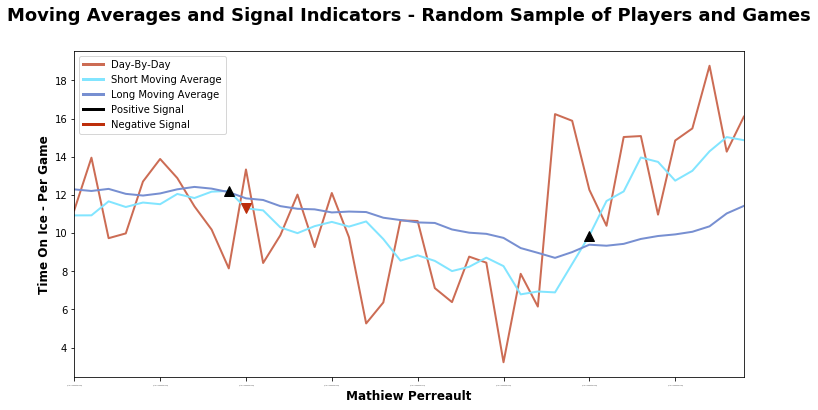

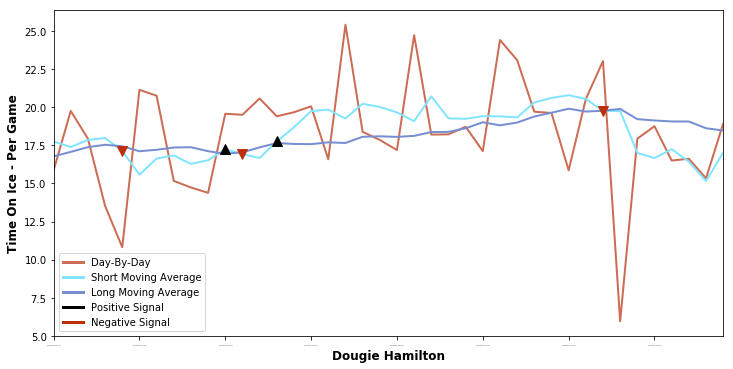

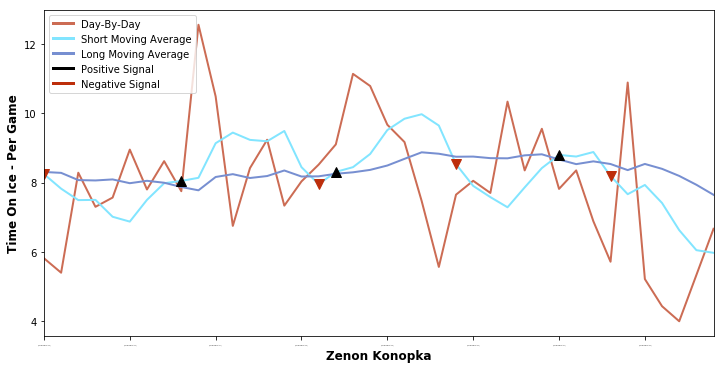

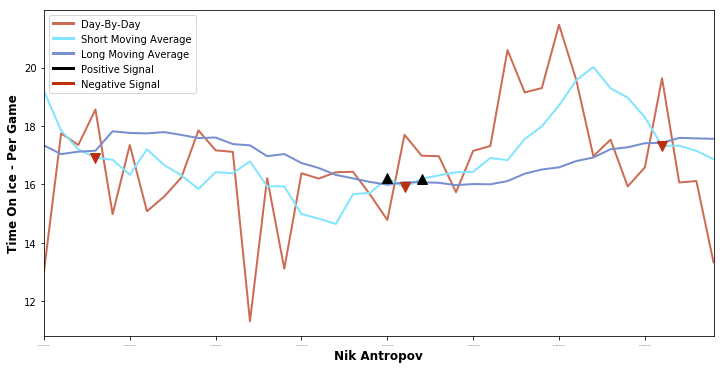

In [29]:
# Import `pyplot` module as `plt`
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Initialize the plot figure
fig = plt.figure(figsize=(12, 6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='MATHIEU.PERREAULT')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['MATHIEU.PERREAULT']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = signals.loc[['MATHIEU.PERREAULT']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('Mathiew Perreault',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')
ax1.set_title('Moving Averages and Signal Indicators - Random Sample of Players and Games', fontsize=18, fontweight='bold',pad=30)



colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)
plt.savefig('MAMP_intial1.png')

# Initialize the plot figure
fig = plt.figure(figsize=(12,6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='DOUGIE.HAMILTON')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['DOUGIE.HAMILTON']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = signals.loc[['DOUGIE.HAMILTON']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('Dougie Hamilton',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')


colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)
plt.savefig('DHMP_intial1.png')
# Initialize the plot figure
fig = plt.figure(figsize=(12,6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='ZENON.KONOPKA')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['ZENON.KONOPKA']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = signals.loc[['ZENON.KONOPKA']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('Zenon Konopka',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')


colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)

plt.savefig('ZPMP_intial1.png')
# Initialize the plot figure
fig = plt.figure(figsize=(12, 6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='Nik Antropov')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['NIK.ANTROPOV']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = signals.loc[['NIK.ANTROPOV']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('Nik Antropov',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')

colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)
# Show the plot
plt.savefig('MA_intial1.png')
plt.show()


What's interesting here is how well it seemed to work in most cases of this random sample particularly with the top two where there were few signals but then a following long trend, but not very well on inconsistant players such as Konopka. Backtesting in this case is slightly non-traditional, in that we're not 'buying anything' so here we'll see how many increased minutes this would have resulted in. 

In [30]:
## merging the tables
signals = signals.merge(player_rolling_avgbs_base[['TOI_comp']],left_index=True, right_index=True)

## change metric, needs to be forward looking hence the -1
signals['change'] = signals.groupby('player')['TOI_comp'].diff(-1).fillna(0) 

## accumulated value as error rate/improvement
signals['value'] = signals['change'] * signals['toi_signal']

print("total increased in given window:", sum(signals['value']))

total increased in given window: 18121.733333333137


In [31]:
game_date = playerbg['game_date']
game_date = pd.DataFrame(game_date)
game_date.reset_index(level=["game_id"],inplace=True)
signals = signals.merge(game_date[['game_date']],left_index=True, right_index=True)

In [32]:
signals.sort_values(by=["game_date","TOI_comp"], inplace=True)
signals['correct_preds'] = signals['value'].cumsum()

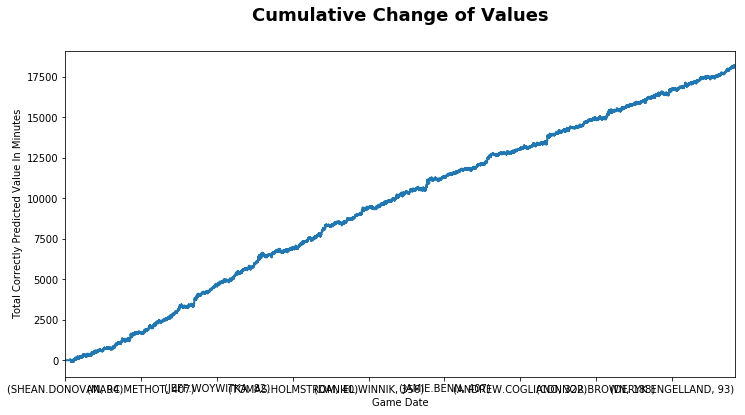

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111, ylabel='Total Correctly Predicted Value In Minutes')

signals['correct_preds'].plot(ax=ax1, lw=2.)

ax1.set_title('Cumulative Change of Values', fontsize=18, fontweight='bold',pad=30)
ax1.set_xlabel('Game Date')
# Show the plot
plt.show()

In [34]:
print(sum(signals['value'])/signals['value'].count()*60)
print(20430/signals['value'].count()*60)

2.462270090084358
2.7759032215695245


From the above we can see that the signals did correctly indicate the values across the range, but while that number of 18121 minutes seems impressive it balances out to a change of less than 3 seconds per game; which is less than a 10th of a shift. To see if there were possibly better values a number of options were then tested by doing a sort of semi-gridsearch across a limited number of values.

In [35]:
x = [3,3,5,5,10,10]
y = [10,20,10,40,20,40]

def changerate(target) :
    changer = []
    for i in range(len(target)):
        loopsignals = pd.DataFrame(index=player_rolling_avgbs_base.index)
        loopsignals['toi_signal'] = 0.0

        # Create short simple moving average over the short window
        loopsignals['TOI_comp'] = player_rolling_avgbs_base['TOI_comp']
        loopsignals['short_mavg'] = player_rolling_avgbs_base.groupby('player')['TOI_comp'].apply(lambda ser: ser.rolling(window=x[i], min_periods=1, center=False).mean().shift().reset_index(level=0, drop=True))

        # Create long simple moving average over the long window
        loopsignals['long_mavg'] = player_rolling_avgbs_base.groupby('player')['TOI_comp'].apply(lambda ser: ser.rolling(window=y[i], min_periods=1, center=False).mean().shift().reset_index(level=0, drop=True))

        # Create signals
        loopsignals['toi_signal'][short_window:] = np.where(loopsignals['short_mavg'][short_window:] > loopsignals['long_mavg'][short_window:], 1.0, 0.0)   

        # Generate trading orders
        ## change metric, needs to be forward looking hence the -1
        loopsignals['change'] = loopsignals.groupby('player')['TOI_comp'].diff(-1).fillna(0) 
        loopsignals['positions'] = loopsignals['toi_signal'].diff()
        ## accumulated value as error rate/improvement
        loopsignals['value'] = loopsignals['change'] * loopsignals['toi_signal']
        loopsignals = loopsignals.merge(game_date[['game_date']],left_index=True, right_index=True)
        loopsignals.sort_values(by=["game_date","TOI_comp"], inplace=True)
        loopsignals['correct_preds'] = loopsignals['value'].cumsum()
        changer.append(loopsignals[['short_mavg', 'long_mavg',"positions",'game_date','value','correct_preds','toi_signal']])

    return(changer)
    

change_grid = changerate(x)

Here we check for the best value and then map that, as well as the same random samples as above.

In [36]:
for i in range(0,6):
    print("value with rolling avgs",x[i],",",y[i],":",round(change_grid[i]["correct_preds"][-1]))

value with rolling avgs 3 , 10 : 18103.0
value with rolling avgs 3 , 20 : 20430.0
value with rolling avgs 5 , 10 : 16144.0
value with rolling avgs 5 , 40 : 20155.0
value with rolling avgs 10 , 20 : 13308.0
value with rolling avgs 10 , 40 : 14189.0


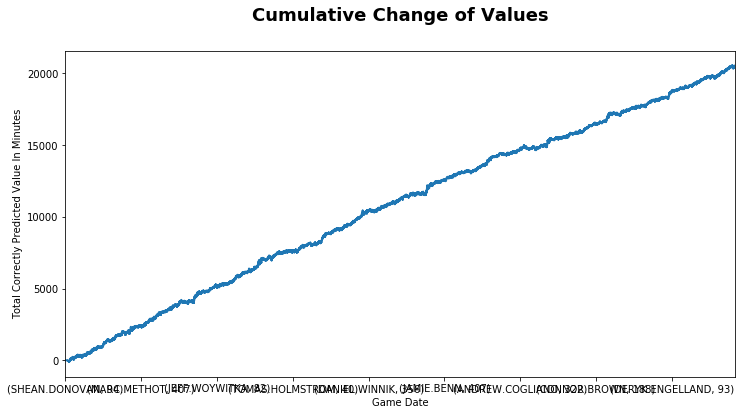

In [37]:
best_val = pd.DataFrame(change_grid[1])

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111, ylabel='Total Correctly Predicted Value In Minutes')

best_val['correct_preds'].plot(ax=ax1, lw=2.)

ax1.set_title('Cumulative Change of Values', fontsize=18, fontweight='bold',pad=30)
ax1.set_xlabel('Game Date')
# Show the plot
plt.show()

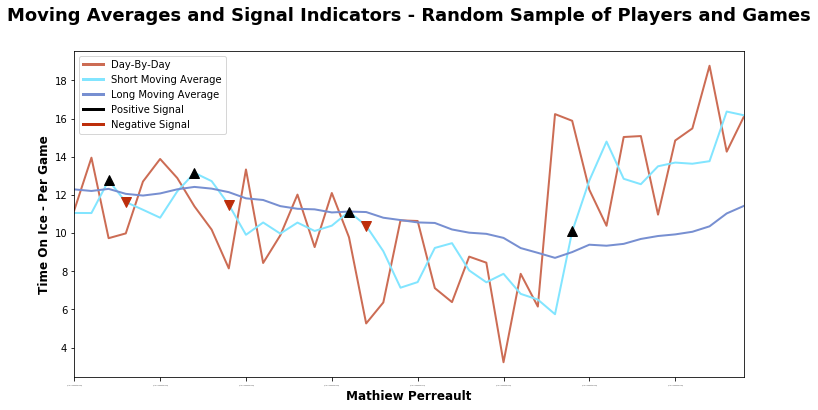

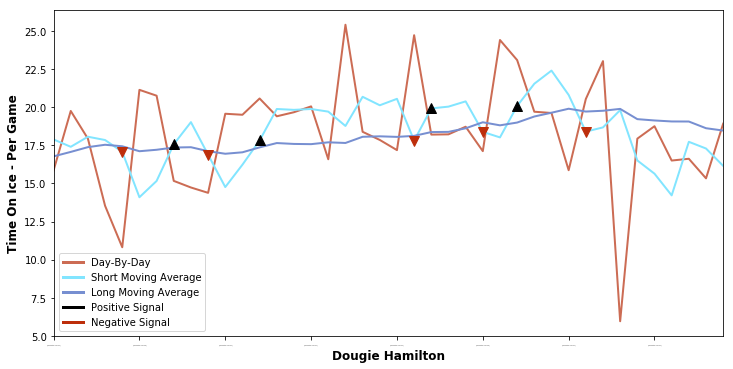

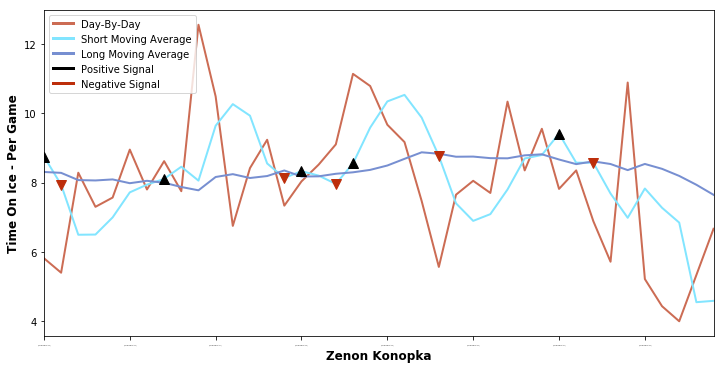

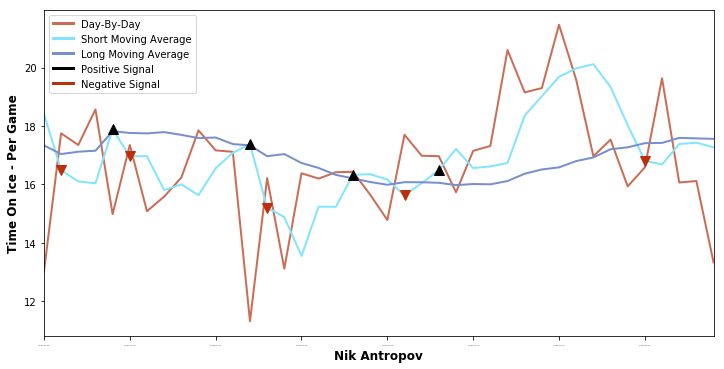

In [38]:
best_val.sort_index(level=["player","game_order"],ascending=False, inplace=True)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Initialize the plot figure
fig = plt.figure(figsize=(12, 6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='MATHIEU.PERREAULT')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['MATHIEU.PERREAULT']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val.loc[['MATHIEU.PERREAULT']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('Mathiew Perreault',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')
ax1.set_title('Moving Averages and Signal Indicators - Random Sample of Players and Games', fontsize=18, fontweight='bold',pad=30)



colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)


# Initialize the plot figure
fig = plt.figure(figsize=(12,6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='DOUGIE.HAMILTON')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['DOUGIE.HAMILTON']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val.loc[['DOUGIE.HAMILTON']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('Dougie Hamilton',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')


colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)

# Initialize the plot figure
fig = plt.figure(figsize=(12,6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='ZENON.KONOPKA')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['ZENON.KONOPKA']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val.loc[['ZENON.KONOPKA']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('Zenon Konopka',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')


colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)


# Initialize the plot figure
fig = plt.figure(figsize=(12, 6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='Nik Antropov')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['NIK.ANTROPOV']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val.loc[['NIK.ANTROPOV']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('Nik Antropov',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')

colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)
# Show the plot


plt.show()



while clear here is that while there is an increase of yield, this might simply bee that the smaller event window is generating more noise rather than an actual signal. Afterall, while this is an increase of about 2000 minutes, that ends up being a grand total of .3 seconds difference per game per row which is the difference of about 1/100th of a shift.

For comparison sake, an OLS model was generated using the moving averages and the signal indicator. 

In [39]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm

X = best_val[['short_mavg', 'long_mavg',"positions", 'toi_signal']].fillna(0)
## we can use the same indexed values from the average tables values as the target since we have retained the same 
y = player_rolling_avgbs_base['TOI_comp'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print( X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(353268, 4) (353268,)
(88318, 4) (88318,)


In [40]:
model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:               TOI_comp   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          3.092e+06
Date:                Mon, 23 Sep 2019   Prob (F-statistic):                        0.00
Time:                        12:04:27   Log-Likelihood:                     -8.7465e+05
No. Observations:              353268   AIC:                                  1.749e+06
Df Residuals:                  353264   BIC:                                  1.749e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The above re-inforces the idea that while the signal does have value, it's not a wildly predictive measure. We can compare it as well to a mode made without the position, and only the moving averages themselves. 

In [41]:
X = best_val[['short_mavg', 'long_mavg']].fillna(0)
## we can use the same indexed values from the average tables values as the target since we have retained the same 
y = player_rolling_avgbs_base['TOI_comp'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:               TOI_comp   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          6.182e+06
Date:                Mon, 23 Sep 2019   Prob (F-statistic):                        0.00
Time:                        12:04:27   Log-Likelihood:                     -8.7472e+05
No. Observations:              353268   AIC:                                  1.749e+06
Df Residuals:                  353266   BIC:                                  1.749e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

As final point of validation, the target metric was shifted to total points, as that is our final target variable. This yeilded aproximately the amount of shift with a much higher R-Squared. Interestingly, the standard error in fact drops, although not significantly, but given the regularized fit here, this does confirm that there is significant value in Time On Ice, albeit not the final metric. 

In [42]:
X = best_val[['short_mavg', 'long_mavg',"positions", 'toi_signal']].fillna(0)
## we can use the same indexed values from the average tables values as the target since we have retained the same 
y = player_rolling_avgbs_base['dk_points'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              dk_points   R-squared (uncentered):                   0.541
Model:                            OLS   Adj. R-squared (uncentered):              0.541
Method:                 Least Squares   F-statistic:                          1.041e+05
Date:                Mon, 23 Sep 2019   Prob (F-statistic):                        0.00
Time:                        12:04:28   Log-Likelihood:                     -7.2697e+05
No. Observations:              353268   AIC:                                  1.454e+06
Df Residuals:                  353264   BIC:                                  1.454e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The next iteration was comparing the shot metric, Fenwick and Corsi as a possible signal with the same moving averages. 

In [43]:
x = [3,3,5,5,10,10]
y = [10,20,10,40,20,40]

def changerate(target) :
    changer = []
    for i in range(len(target)):
        loopsignals = pd.DataFrame(index=player_rolling_avgbs_base.index)
        loopsignals['FF_signal'] = 0.0

        # Create short simple moving average over the short window
        loopsignals['iFF_comp'] = player_rolling_avgbs_base['iFF_comp']
        loopsignals['short_mavg'] = player_rolling_avgbs_base.groupby('player')['iFF_comp'].apply(lambda ser: ser.rolling(window=x[i], min_periods=1, center=False).mean().shift().reset_index(level=0, drop=True))

        # Create long simple moving average over the long window
        loopsignals['long_mavg'] = player_rolling_avgbs_base.groupby('player')['iFF_comp'].apply(lambda ser: ser.rolling(window=y[i], min_periods=1, center=False).mean().shift().reset_index(level=0, drop=True))

        # Create signals
        loopsignals['FF_signal'][short_window:] = np.where(loopsignals['short_mavg'][short_window:] > loopsignals['long_mavg'][short_window:], 1.0, 0.0)   

        # Generate trading orders
        ## change metric, needs to be forward looking hence the -1
        loopsignals['change'] = loopsignals.groupby('player')['iFF_comp'].diff(-1).fillna(0) 
        loopsignals['positions'] = loopsignals['FF_signal'].diff()
        ## accumulated value as error rate/improvement
        loopsignals['value'] = loopsignals['change'] * loopsignals['FF_signal']
        loopsignals = loopsignals.merge(game_date[['game_date']],left_index=True, right_index=True)
        loopsignals.sort_values(by=["game_date","iFF_comp"], inplace=True)
        loopsignals['correct_preds'] = loopsignals['value'].cumsum()
        changer.append(loopsignals[['short_mavg', 'long_mavg',"positions",'game_date','value','correct_preds','FF_signal']])

    return(changer)
    

FFchange_grid = changerate(x)

for i in range(0,6):
    print("value with rolling avgs",x[i],",",y[i],":",round(FFchange_grid[i]["correct_preds"][-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


value with rolling avgs 3 , 10 : 1972.0
value with rolling avgs 3 , 20 : 2597.0
value with rolling avgs 5 , 10 : 1771.0
value with rolling avgs 5 , 40 : 2206.0
value with rolling avgs 10 , 20 : 1571.0
value with rolling avgs 10 , 40 : 1397.0


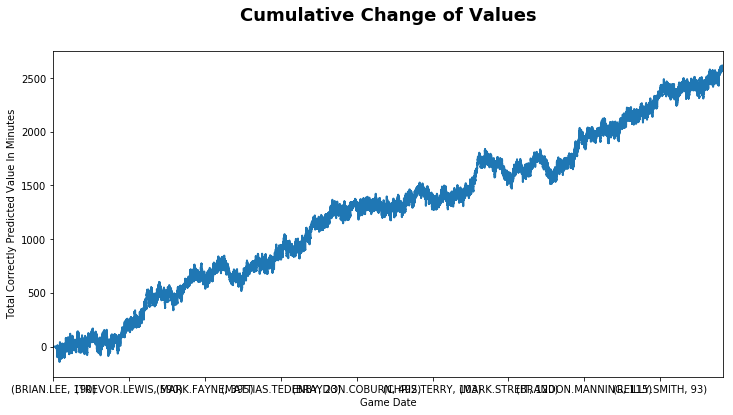

In [44]:
best_val_ff = pd.DataFrame(FFchange_grid[1])

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111, ylabel='Total Correctly Predicted Value In Minutes')

best_val_ff['correct_preds'].plot(ax=ax1, lw=2.)

ax1.set_title('Cumulative Change of Values', fontsize=18, fontweight='bold',pad=30)
ax1.set_xlabel('Game Date')
# Show the plot
plt.show()

For the visual a new random cohort was selected to inform the metric based on getting a random distribution of fenwick values. Please note these values were randomly selected but apparently Zenon Konopka is our everyman.

In [45]:
player_rolling_avgbs_base.sample(n=4, weights='iFF_comp', random_state=1)

,,game_id,TOI_comp,G_comp,Points_comp,iFF_comp,iCF_comp,ixG_comp,TOI_ev,G_ev,Points_ev,iFF_ev,iCF_ev,ixG_ev,onGF,onFF,onCF,onxGF,TOI,G,Points,iSF,iFF,iCF,ixG,onGF_pp,onFF_pp,onCF_pp,onxGF_pp,dk_points,skater_toi_percentage,skater_pptoi_percentage,skater_shtoi_percentage,points_per_60,iFF_per_60,ixG_per_60,game_id_lag,TOI_comp_lag,G_comp_lag,Points_comp_lag,iFF_comp_lag,iCF_comp_lag,ixG_comp_lag,TOI_ev_lag,G_ev_lag,Points_ev_lag,iFF_ev_lag,iCF_ev_lag,ixG_ev_lag,onGF_lag,onFF_lag,onCF_lag,onxGF_lag,TOI_lag,G_lag,Points_lag,iSF_lag,iFF_lag,iCF_lag,ixG_lag,onGF_pp_lag,onFF_pp_lag,onCF_pp_lag,onxGF_pp_lag,dk_points_lag,skater_toi_percentage_lag,skater_pptoi_percentage_lag,skater_shtoi_percentage_lag,points_per_60_lag,iFF_per_60_lag,ixG_per_60_lag,game_id_lag_astt_std,game_id_lag_astf_std,game_id_lag_astten_std,game_id_lag_asttwen_std,game_id_lag_lastt,game_id_lag_lastf,game_id_lag_lastten,game_id_lag_lasttwen,TOI_comp_lag_astt_std,TOI_comp_lag_astf_std,TOI_comp_lag_astten_std,TOI_comp_lag_asttwen_std,TOI_comp_lag_lastt,TOI_comp_lag_lastf,TOI_comp_lag_lastten,TOI_comp_lag_lasttwen,G_comp_lag_astt_std,G_comp_lag_astf_std,G_comp_lag_astten_std,G_comp_lag_asttwen_std,G_comp_lag_lastt,G_comp_lag_lastf,G_comp_lag_lastten,G_comp_lag_lasttwen,Points_comp_lag_astt_std,Points_comp_lag_astf_std,Points_comp_lag_astten_std,Points_comp_lag_asttwen_std,Points_comp_lag_lastt,Points_comp_lag_lastf,Points_comp_lag_lastten,Points_comp_lag_lasttwen,iFF_comp_lag_astt_std,iFF_comp_lag_astf_std,iFF_comp_lag_astten_std,iFF_comp_lag_asttwen_std,iFF_comp_lag_lastt,iFF_comp_lag_lastf,iFF_comp_lag_lastten,iFF_comp_lag_lasttwen,iCF_comp_lag_astt_std,iCF_comp_lag_astf_std,iCF_comp_lag_astten_std,iCF_comp_lag_asttwen_std,iCF_comp_lag_lastt,iCF_comp_lag_lastf,iCF_comp_lag_lastten,iCF_comp_lag_lasttwen,ixG_comp_lag_astt_std,ixG_comp_lag_astf_std,ixG_comp_lag_astten_std,ixG_comp_lag_asttwen_std,ixG_comp_lag_lastt,ixG_comp_lag_lastf,ixG_comp_lag_lastten,ixG_comp_lag_lasttwen,TOI_ev_lag_astt_std,TOI_ev_lag_astf_std,TOI_ev_lag_astten_std,TOI_ev_lag_asttwen_std,TOI_ev_lag_lastt,TOI_ev_lag_lastf,TOI_ev_lag_lastten,TOI_ev_lag_lasttwen,G_ev_lag_astt_std,G_ev_lag_astf_std,G_ev_lag_astten_std,G_ev_lag_asttwen_std,G_ev_lag_lastt,G_ev_lag_lastf,G_ev_lag_lastten,G_ev_lag_lasttwen,Points_ev_lag_astt_std,Points_ev_lag_astf_std,Points_ev_lag_astten_std,Points_ev_lag_asttwen_std,Points_ev_lag_lastt,Points_ev_lag_lastf,Points_ev_lag_lastten,Points_ev_lag_lasttwen,iFF_ev_lag_astt_std,iFF_ev_lag_astf_std,iFF_ev_lag_astten_std,iFF_ev_lag_asttwen_std,iFF_ev_lag_lastt,iFF_ev_lag_lastf,iFF_ev_lag_lastten,iFF_ev_lag_lasttwen,iCF_ev_lag_astt_std,iCF_ev_lag_astf_std,iCF_ev_lag_astten_std,iCF_ev_lag_asttwen_std,iCF_ev_lag_lastt,iCF_ev_lag_lastf,iCF_ev_lag_lastten,iCF_ev_lag_lasttwen,ixG_ev_lag_astt_std,ixG_ev_lag_astf_std,ixG_ev_lag_astten_std,ixG_ev_lag_asttwen_std,ixG_ev_lag_lastt,ixG_ev_lag_lastf,ixG_ev_lag_lastten,ixG_ev_lag_lasttwen,onGF_lag_astt_std,onGF_lag_astf_std,onGF_lag_astten_std,onGF_lag_asttwen_std,onGF_lag_lastt,onGF_lag_lastf,onGF_lag_lastten,onGF_lag_lasttwen,onFF_lag_astt_std,onFF_lag_astf_std,onFF_lag_astten_std,onFF_lag_asttwen_std,onFF_lag_lastt,onFF_lag_lastf,onFF_lag_lastten,onFF_lag_lasttwen,onCF_lag_astt_std,onCF_lag_astf_std,onCF_lag_astten_std,onCF_lag_asttwen_std,onCF_lag_lastt,onCF_lag_lastf,onCF_lag_lastten,onCF_lag_lasttwen,onxGF_lag_astt_std,onxGF_lag_astf_std,onxGF_lag_astten_std,onxGF_lag_asttwen_std,onxGF_lag_lastt,onxGF_lag_lastf,onxGF_lag_lastten,onxGF_lag_lasttwen,TOI_lag_astt_std,TOI_lag_astf_std,TOI_lag_astten_std,TOI_lag_asttwen_std,TOI_lag_lastt,TOI_lag_lastf,TOI_lag_lastten,TOI_lag_lasttwen,G_lag_astt_std,G_lag_astf_std,G_lag_astten_std,G_lag_asttwen_std,G_lag_lastt,G_lag_lastf,G_lag_lastten,G_lag_lasttwen,Points_lag_astt_std,Points_lag_astf_std,Points_lag_astten_std,Points_lag_asttwen_std,Points_lag_lastt,Points_lag_lastf,Points_lag_lastten,Points_lag_lasttwen,iSF_lag_astt_std,iSF_lag_astf_std,iSF_lag_astten_std,iSF_lag_asttwen_std,iSF_lag_lastt,i

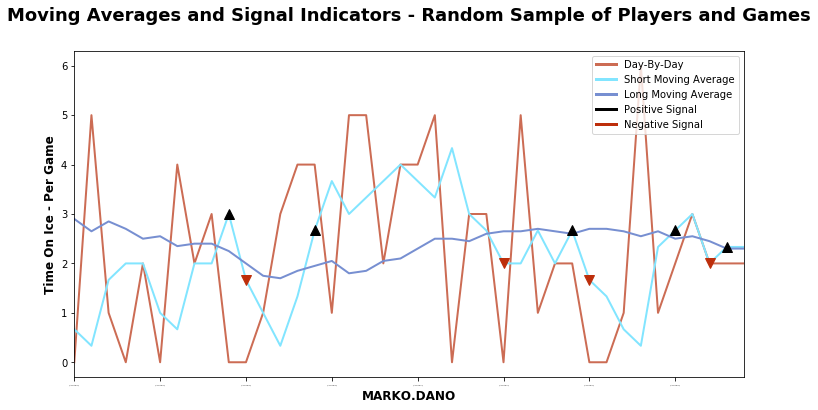

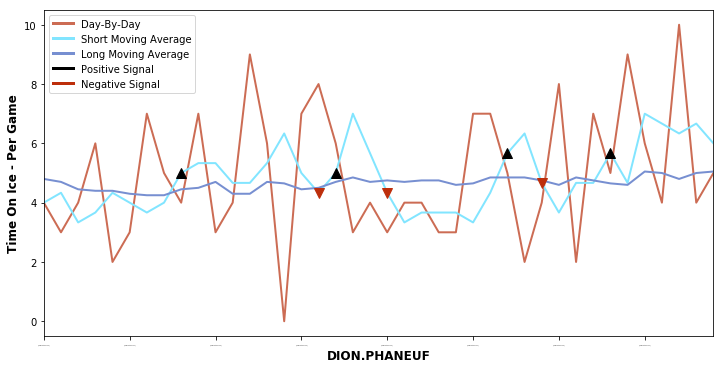

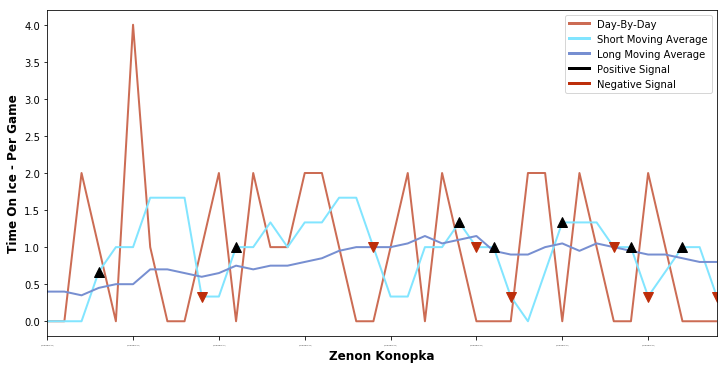

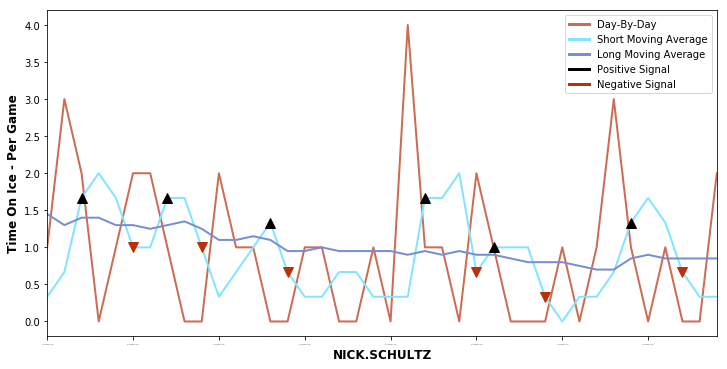

In [46]:
best_val_ff.sort_index(level=["player","game_order"],ascending=False, inplace=True)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Initialize the plot figure
fig = plt.figure(figsize=(12, 6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='MARKO.DANO')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['MARKO.DANO']][30:70]['iFF_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val_ff.loc[['MARKO.DANO']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('MARKO.DANO',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')
ax1.set_title('Moving Averages and Signal Indicators - Random Sample of Players and Games', fontsize=18, fontweight='bold',pad=30)



colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)


# Initialize the plot figure
fig = plt.figure(figsize=(12,6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='DION.PHANEUF')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['DION.PHANEUF']][30:70]['iFF_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val_ff.loc[['DION.PHANEUF']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('DION.PHANEUF',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')


colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)

# Initialize the plot figure
fig = plt.figure(figsize=(12,6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='ZENON.KONOPKA')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['ZENON.KONOPKA']][30:70]['iFF_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val_ff.loc[['ZENON.KONOPKA']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('Zenon Konopka',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')


colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)


# Initialize the plot figure
fig = plt.figure(figsize=(12, 6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='Nik Antropov')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['NICK.SCHULTZ']][30:70]['iFF_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val_ff.loc[['NICK.SCHULTZ']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('NICK.SCHULTZ',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')

colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)
# Show the plot
plt.show()




This Chart series was an accient, laying over time on ice as the top line with the fenwick lines at the bottom, but what's interesting here is the trends seem to correlate here as well. This would merit some study as well in a different project.

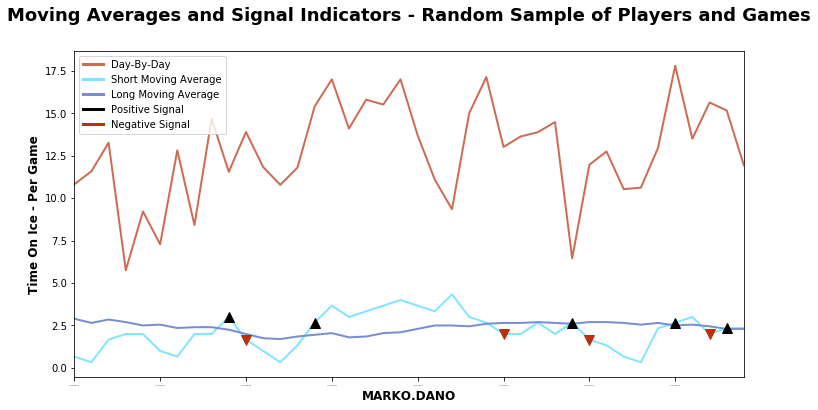

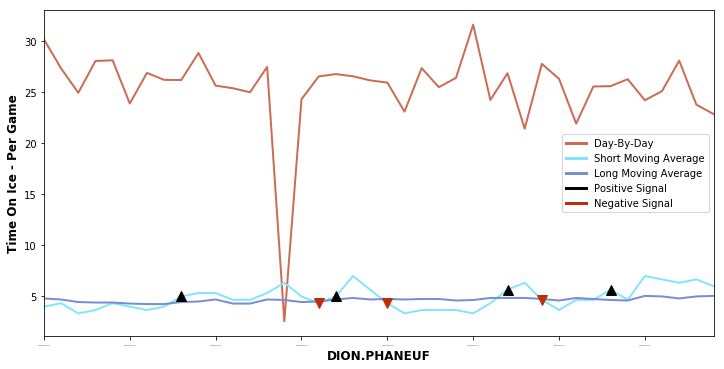

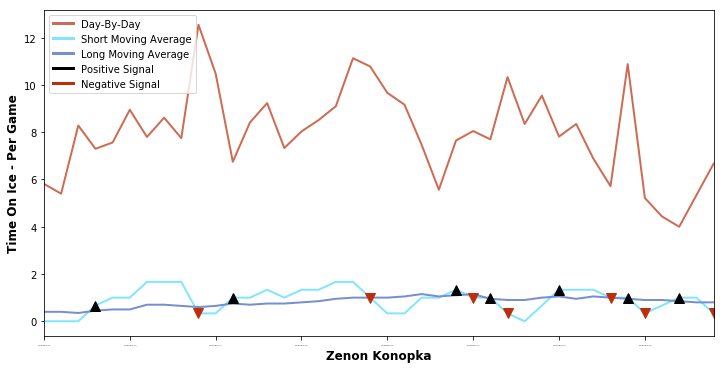

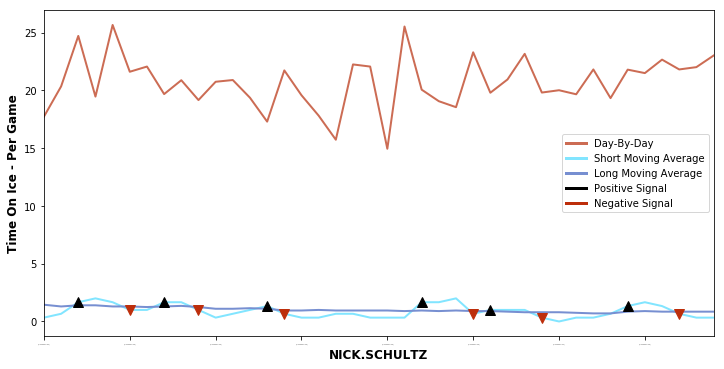

In [47]:
best_val_ff.sort_index(level=["player","game_order"],ascending=False, inplace=True)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Initialize the plot figure
fig = plt.figure(figsize=(12, 6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='MARKO.DANO')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['MARKO.DANO']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val_ff.loc[['MARKO.DANO']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('MARKO.DANO',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')
ax1.set_title('Moving Averages and Signal Indicators - Random Sample of Players and Games', fontsize=18, fontweight='bold',pad=30)



colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)


# Initialize the plot figure
fig = plt.figure(figsize=(12,6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='DION.PHANEUF')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['DION.PHANEUF']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val_ff.loc[['DION.PHANEUF']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('DION.PHANEUF',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')


colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)

# Initialize the plot figure
fig = plt.figure(figsize=(12,6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='ZENON.KONOPKA')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['ZENON.KONOPKA']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val_ff.loc[['ZENON.KONOPKA']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('Zenon Konopka',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')


colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)


# Initialize the plot figure
fig = plt.figure(figsize=(12, 6))


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, xlabel='Nik Antropov')

plt.tick_params(axis='x', which='major', labelsize=1)
# Plot the closing price
player_rolling_avgbs_base.loc[['NICK.SCHULTZ']][30:70]['TOI_comp'].plot(ax=ax1, color='#CC6C54', lw=2.)

# Plot the short and long moving averages
mp = best_val_ff.loc[['NICK.SCHULTZ']][30:70].reset_index()


mp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ["#82E5FF","#778FD1"])

ax1.set_xlabel('NICK.SCHULTZ',fontsize='large', fontweight='bold')
ax1.set_ylabel('Time On Ice - Per Game',fontsize='large', fontweight='bold')
# Plot the buy signals
ax1.plot(mp.loc[mp.positions == 1.0].index, mp.short_mavg[mp.positions == 1.0],'^', markersize=10, color='#000000')
         
# Plot the sell signals
ax1.plot(mp.loc[mp.positions == -1.0].index, mp.short_mavg[mp.positions == -1.0],'v', markersize=10, color='#BD2E0B')

colors = ['#CC6C54',"#82E5FF","#778FD1",'#000000','#BD2E0B']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Day-By-Day', 'Short Moving Average', 'Long Moving Average',"Positive Signal", "Negative Signal"]
plt.legend(lines, labels)
# Show the plot
plt.show()

In [48]:
X = best_val_ff[['short_mavg', 'long_mavg',"positions", 'FF_signal']].fillna(0)
## we can use the same indexed values from the average tables values as the target since we have retained the same 
y = player_rolling_avgbs_base['iFF_comp'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:               iFF_comp   R-squared (uncentered):                   0.692
Model:                            OLS   Adj. R-squared (uncentered):              0.692
Method:                 Least Squares   F-statistic:                          1.986e+05
Date:                Mon, 23 Sep 2019   Prob (F-statistic):                        0.00
Time:                        12:05:26   Log-Likelihood:                     -6.8397e+05
No. Observations:              353268   AIC:                                  1.368e+06
Df Residuals:                  353264   BIC:                                  1.368e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [49]:
X = best_val_ff[['short_mavg', 'long_mavg',"positions", 'FF_signal']].fillna(0)
## we can use the same indexed values from the average tables values as the target since we have retained the same 
y = player_rolling_avgbs_base['dk_points'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              dk_points   R-squared (uncentered):                   0.564
Model:                            OLS   Adj. R-squared (uncentered):              0.564
Method:                 Least Squares   F-statistic:                          1.141e+05
Date:                Mon, 23 Sep 2019   Prob (F-statistic):                        0.00
Time:                        12:05:27   Log-Likelihood:                     -7.1802e+05
No. Observations:              353268   AIC:                                  1.436e+06
Df Residuals:                  353264   BIC:                                  1.436e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

What's perhaps most interesting here is dependant variable here actually decreases with the short moving average in both instances, but the long average and the Fenwick Signal seems to be worth almost a half a point, which in terms of an 8 man fantasy hockey team where difference between a cashing in a tournament or not is often far less than that. 

The remaining features were then combined to make one master table and prepared for the final segment of models.

In [50]:
final_signals = best_val.merge(best_val_ff,left_index=True, right_index=True)
new_cols = [col for col in final_signals.columns if '_signal' in col]
final_signals = final_signals[new_cols]

final_signals

toi_signal  FF_signal
player        game_order                       
ZENON.KONOPKA 301                0.0        0.0
              300                0.0        0.0
              299                0.0        0.0
              298                0.0        0.0
              297                0.0        0.0
...                              ...        ...
A.J..GREER    5                  1.0        1.0
              4                  1.0        1.0
              3                  0.0        1.0
              2                  0.0        0.0
              1                  0.0        1.0

[441586 rows x 2 columns]

In [51]:
player_avgs_base = player_avgs_base.merge(final_signals,left_index=True, right_index=True)

player_avgs_base.set_index("game_id",inplace=True,  append=True)
player_avgs_base.head()

TOI_comp  G_comp  Points_comp  iSF_comp  \
player        game_order game_id                                               
ZENON.KONOPKA 301        2008020405  0.783333       0            0         0   
              300        2008020416  5.266667       0            0         0   
              299        2008020433  3.366667       0            0         0   
              298        2008021168  7.700000       0            0         1   
              297        2008021190  9.966667       0            0         2   

                                     iFF_comp  iCF_comp  ixG_comp  iBLK_comp  \
player        game_order game_id                                               
ZENON.KONOPKA 301        2008020405         0         0       0.0          0   
              300        2008020416         0         1       0.0          0   
              299        2008020433         0         0       0.0          0   
              298        2008021168         1         1       0.0          0   
              297        2008021190         2         2       0.0          0   

                                     iHF  OZS_comp    TOI_ev  G_ev  Points_ev  \
player        game_order game_id                                                
ZENON.KONOPKA 301        2008020405    0         0  0.700000   0.0        0.0   
              300        2008020416    2         2  5.266667   0.0        0.0   
              299        2008020433    1         2  3.366667   0.0        0.0   
              298        2008021168    1         2  7.700000   0.0        0.0   
              297        2008021190    0         3  9.916667   0.0        0.0   

                                     iSF_ev  iFF_ev  iCF_ev  ixG_ev  iBLK_ev  \
player        game_order game_id                                               
ZENON.KONOPKA 301        2008020405     0.0     0.0     0.0     0.0      0.0   
              300        2008020416     0.0     0.0     1.0     0.0      0.0   
              299        2008020433     0.0     0.0     0.0     0.0      0.0   
              298        2008021168     1.0     1.0     1.0     0.0      0.0   
              297        2008021190     2.0     2.0     2.0     0.0      0.0   

                                     onGF  onFF  onCF  onxGF  onFA_state  \
player        game_order game_id                                           
ZENON.KONOPKA 301        2008020405   0.0   1.0   1.0    0.0         0.0   
              300        2008020416   0.0   4.0   7.0    0.0         2.0   
              299        2008020433   0.0   3.0   5.0    0.0         1.0   
              298        2008021168   0.0   3.0   4.0    0.0         6.0   
              297        2008021190   0.0   4.0   6.0    0.0         6.0   

                                          TOI    G  Points  iSF  iFF  iCF  \
player        game_order game_id                                            
ZENON.KONOPKA 301        2008020405  0.083333  0.0     0.0  0.0  0.0  0.0   
              300        2008020416  0.000000  0.0     0.0  0.0  0.0  0.0   
              299        2008020433  0.000000  0.0     0.0  0.0  0.0  0.0   
              298        2008021168  0.000000  0.0     0.0  0.0  0.0  0.0   
              297        2008021190  0.050000  0.0     0.0  0.0  0.0  0.0   

                                     ixG  onGF_pp  onSF_pp  onFF_pp  onCF_pp  \
player        game_order game_id                                               
ZENON.KONOPKA 301        2008020405  0.0      0.0      0.0      0.0      0.0   
              300        2008020416  0.0      0.0      0.0      0.0      0.0   
              299        2008020433  0.0      0.0      0.0      0.0      0.0   
              298        2008021168  0.0      0.0      0.0      0.0      0.0   
              297        2008021190  0.0      0.0      0.0      0.0      0.0   

                                     onxGF_pp  TOI_sh  G_sh  Points_sh  \
player        game_order game_id                                         
ZENO

In [52]:
new_cols = [col for col in player_avgs_base.columns if '_avg' in col]


playerbg_jo = pd.merge(playerbg, player_avgs_base[new_cols], left_on=['player','game_id', 'game_order'],right_on=['player','game_id','game_order'],how='outer',suffixes=('','_avgt'))
playerbg_jo.head()

index  game_date  season_comp Team_comp  \
player        game_id    game_order                                             
ZENON.KONOPKA 2013021047 2           441584 2014-03-20     20132014       BUF   
A.J..GREER    2016020268 35               2 2016-11-19     20162017       COL   
              2016020278 34               3 2016-11-21     20162017       COL   
              2016020296 33               4 2016-11-23     20162017       COL   
              2017020134 32               5 2017-10-24     20172018       COL   

                                    Opponent_comp  is_home_comp   TOI_comp  \
player        game_id    game_order                                          
ZENON.KONOPKA 2013021047 2                    EDM             0   5.916667   
A.J..GREER    2016020268 35                   MIN             0  12.700000   
              2016020278 34                   CBJ             0  15.433333   
              2016020296 33                   EDM             1  11.850000   
              2017020134 32                   DAL             1   8.366667   

                                     G_comp  A1_comp  A2_comp  Points_comp  \
player        game_id    game_order                                          
ZENON.KONOPKA 2013021047 2                0        0        0            0   
A.J..GREER    2016020268 35               0        0        0            0   
              2016020278 34               0        0        0            0   
              2016020296 33               0        0        0            0   
              2017020134 32               0        0        0            0   

                                     iSF_comp  iFF_comp  iCF_comp  ixG_comp  \
player        game_id    game_order                                           
ZENON.KONOPKA 2013021047 2                  1         1         1  0.000005   
A.J..GREER    2016020268 35                 0         1         1  0.000019   
              2016020278 34                 4         4         4  0.152344   
              2016020296 33                 0         0         1  0.000000   
              2017020134 32                 2         2         2  0.220729   

                                     iBLK_comp  iHF  iHA  GIVE  TAKE  \
player        game_id    game_order                                    
ZENON.KONOPKA 2013021047 2                   0    0    0     0     0   
A.J..GREER    2016020268 35                  0    1    3     0     0   
              2016020278 34                  2    3    0     1     0   
              2016020296 33                  1    0    1     0     0   
              2017020134 32                  1    3    0     0     0   

                                     iPENT2_comp  iPEND2_comp  iPENT5_comp  \
player        game_id    game_order                                          
ZENON.KONOPKA 2013021047 2                     1            1            0   
A.J..GREER    2016020268 35                    1            1            0   
              2016020278 34                    0            0            0   
              2016020296 33                    1            1            0   
              2017020134 32                    0            0            0   

                                     iPEND5_comp  FOW_comp  FOL_comp  \
player        game_id    game_order                                    
ZENON.KONOPKA 2013021047 2                     0         4         9   
A.J..GREER    2016020268 35                    0         0         0   
              2016020278 34                    0         0         0   
              2016020296 33                    0         0         0   
              2017020134 32                    0         0         0   

                                     OZS_comp  NZS_comp  DZS_comp  t_TOI_comp  \
player        game_id    game_order                                             
ZENON.KONOPKA 2013021047 2                  2         2         9   60.000000   
A.J..GREER    20160202

In [53]:
## worked nicely there, adding to the remainder
## we are dropping any columns here that already exist in the base table

player_avgs_base2.set_index("game_id",inplace=True,  append=True)
player_avgs_base3.set_index("game_id",inplace=True,  append=True)
player_avgs_base4.set_index("game_id",inplace=True,  append=True)

new_cols = [col for col in player_avgs_base2.columns if '_avg' in col]


playerbg_jo_f = pd.merge(playerbg_jo, player_avgs_base2[new_cols], left_on=['player','game_id', 'game_order'],right_on=['player','game_id','game_order'],how='outer',suffixes=('','_avgf'))

new_cols = [col for col in player_avgs_base3.columns if '_avg' in col]


playerbg_jo_t = pd.merge(playerbg_jo_f, player_avgs_base3[new_cols], left_on=['player','game_id', 'game_order'],right_on=['player','game_id','game_order'],how='outer',suffixes=('','_avgten'))


new_cols = [col for col in player_avgs_base4.columns if '_avg' in col]


playerbg_jo_twenty = pd.merge(playerbg_jo_t, player_avgs_base4[new_cols], left_on=['player','game_id', 'game_order'],right_on=['player','game_id','game_order'],how='outer',suffixes=('','_avgtwn'))

In [54]:
final_signals = best_val.merge(best_val_ff,left_index=True, right_index=True)
new_cols = [col for col in final_signals.columns if '_signal' in col]
final_signals = final_signals[new_cols]

playerbg_jo_twenty = playerbg_jo_twenty.merge(final_signals,left_index=True, right_index=True)


In [55]:
playerbg_jo_twenty.shape

(441586, 487)

In [56]:
playerbg_jo_twenty.head()

,,,index,game_date,season_comp,Team_comp,Opponent_comp,is_home_comp,TOI_comp,G_comp,A1_comp,A2_comp,Points_comp,iSF_comp,iFF_comp,iCF_comp,ixG_comp,iBLK_comp,iHF,iHA,GIVE,TAKE,iPENT2_comp,iPEND2_comp,iPENT5_comp,iPEND5_comp,FOW_comp,FOL_comp,OZS_comp,NZS_comp,DZS_comp,t_TOI_comp,TOI_ev,G_ev,A1_ev,A2_ev,Points_ev,iSF_ev,iFF_ev,iCF_ev,ixG_ev,iBLK_ev,GIVE_o,GIVE_n,GIVE_d,TAKE_o,TAKE_n,TAKE_d,iHF_o,iHF_n,iHF_d,iHA_o,iHA_n,iHA_d,FOW_ev,FOL_ev,OZS_ev,NZS_ev,DZS_ev,iPENT2_ev,iPEND2_ev,iPENT5_ev,iPEND5_ev,onGF,onGA,onSF,onSA,onFF,onFA,onCF,onCA,onxGF,onxGA,onGF_state,onGA_state,onSF_state,onSA_state,onFF_state,onFA_state,onCF_state,onCA_state,onxGF_state,onxGA_state,t_TOI_ev,t_GF,t_GA,t_SF,t_SA,t_FF,t_FA,t_CF,t_CA,t_xGF,t_xGA,t_GF_state,t_GA_state,t_SF_state,t_SA_state,t_FF_state,t_FA_state,t_CF_state,t_CA_state,t_xGF_state,t_xGA_state,TOI,G,A1,A2,Points,iSF,iFF,iCF,ixG,GIVE_o_pp,GIVE_n_pp,GIVE_d_pp,TAKE_o_pp,TAKE_n_pp,TAKE_d_pp,iHF_o_pp,iHF_n_pp,iHF_d_pp,iHA_o_pp,iHA_n_pp,iHA_d_pp,FOW,FOL,OZS,NZS,DZS,iPENT2,iPEND2,iPENT5,iPEND5,onGF_pp,onGA_pp,onSF_pp,onSA_pp,onFF_pp,onFA_pp,onCF_pp,onCA_pp,onxGF_pp,onxGA_pp,onGF_state_pp,onGA_state_pp,onSF_state_pp,onSA_state_pp,onFF_state_pp,onFA_state_pp,onCF_state_pp,onCA_state_pp,onxGF_state_pp,onxGA_state_pp,t_TOI,t_GF_pp,t_GA_pp,t_SF_pp,t_SA_pp,t_FF_pp,t_FA_pp,t_CF_pp,t_CA_pp,t_xGF_pp,t_xGA_pp,t_GF_state_pp,t_GA_state_pp,t_SF_state_pp,t_SA_state_pp,t_FF_state_pp,t_FA_state_pp,t_CF_state_pp,t_CA_state_pp,t_xGF_state_pp,t_xGA_state_pp,TOI_sh,G_sh,A1_sh,A2_sh,Points_sh,iSF_sh,iFF_sh,iCF_sh,ixG_sh,iBLK,GIVE_o_sh,GIVE_n_sh,GIVE_d_sh,TAKE_o_sh,TAKE_n_sh,TAKE_d_sh,iHF_o_sh,iHF_n_sh,iHF_d_sh,iHA_o_sh,iHA_n_sh,iHA_d_sh,FOW_sh,FOL_sh,OZS_sh,NZS_sh,DZS_sh,iPENT2_sh,iPEND2_sh,iPENT5_sh,iPEND5_sh,onGF_sh,onGA_sh,onSF_sh,onSA_sh,onFF_sh,onFA_sh,onCF_sh,onCA_sh,onxGF_sh,onxGA_sh,onGF_state_sh,onGA_state_sh,onSF_state_sh,onSA_state_sh,onFF_state_sh,onFA_state_sh,onCF_state_sh,onCA_state_sh,onxGF_state_sh,onxGA_state_sh,t_TOI_sh,t_GF_sh,t_GA_sh,t_SF_sh,t_SA_sh,t_FF_sh,t_FA_sh,t_CF_sh,t_CA_sh,t_xGF_sh,t_xGA_sh,t_GF_state_sh,t_GA_state_sh,t_SF_state_sh,t_SA_state_sh,t_FF_state_sh,t_FA_state_sh,t_CF_state_sh,t_CA_state_sh,t_xGF_state_sh,t_xGA_state_sh,hat_trick,dk_points,skater_toi_percentage,skater_pptoi_percentage,skater_shtoi_percentage,points_per_60,iFF_per_60,ixG_per_60,position,position_type,firstname,lastname,game_id_avg_lt,TOI_comp_avg_lt,G_comp_avg_lt,Points_comp_avg_lt,iSF_comp_avg_lt,iFF_comp_avg_lt,iCF_comp_avg_lt,ixG_comp_avg_lt,iBLK_comp_avg_lt,iHF_avg_lt,OZS_comp_avg_lt,TOI_ev_avg_lt,G_ev_avg_lt,Points_ev_avg_lt,iSF_ev_avg_lt,iFF_ev_avg_lt,iCF_ev_avg_lt,ixG_ev_avg_lt,iBLK_ev_avg_lt,onGF_avg_lt,onFF_avg_lt,onCF_avg_lt,onxGF_avg_lt,onFA_state_avg_lt,TOI_avg_lt,G_avg_lt,Points_avg_lt,iSF_avg_lt,iFF_avg_lt,iCF_avg_lt,ixG_avg_lt,onGF_pp_avg_lt,onSF_pp_avg_lt,onFF_pp_avg_lt,onCF_pp_avg_lt,onxGF_pp_avg_lt,TOI_sh_avg_lt,G_sh_avg_lt,Points_sh_avg_lt,iSF_sh_avg_lt,iFF_sh_avg_lt,iCF_sh_avg_lt,ixG_sh_avg_lt,onGF_sh_avg_lt,onSF_sh_avg_lt,onFF_sh_avg_lt,onCF_sh_avg_lt,onxGF_sh_avg_lt,onxGA_sh_avg_lt,hat_trick_avg_lt,dk_points_avg_lt,skater_toi_percentage_avg_lt,skater_pptoi_percentage_avg_lt,skater_shtoi_percentage_avg_lt,points_per_60_avg_lt,iFF_per_60_avg_lt,ixG_per_60_avg_lt,game_id_avg_lf,TOI_comp_avg_lf,G_comp_avg_lf,Points_comp_avg_lf,iSF_comp_avg_lf,iFF_comp_avg_lf,iCF_comp_avg_lf,ixG_comp_avg_lf,iBLK_comp_avg_lf,iHF_avg_lf,OZS_comp_avg_lf,TOI_ev_avg_lf,G_ev_avg_lf,Points_ev_avg_lf,iSF_ev_avg_lf,iFF_ev_avg_lf,iCF_ev_avg_lf,ixG_ev_avg_lf,iBLK_ev_avg_lf,onGF_avg_lf,onFF_avg_lf,onCF_avg_lf,onxGF_avg_lf,onFA_state_avg_lf,TOI_avg_lf,G_avg_lf,Points_avg_lf,iSF_avg_lf,iFF_avg_lf,iCF_avg_lf,ixG_avg_lf,onGF_pp_avg_lf,onSF_pp_avg_lf,onFF_pp_avg_lf,onCF_pp_avg_lf,onxGF_pp_avg_lf,TOI_sh_avg_lf,G_sh_avg_lf,Points_sh_avg_lf,iSF_sh_avg_lf,iFF_sh_avg_lf,iCF_sh_avg_lf,ixG_sh_avg_lf,onGF_sh_avg_lf,onSF_sh_avg_lf,onFF_sh_avg_lf,onCF_sh_avg_lf,onxGF_sh_avg_lf,onxGA_sh_avg_lf,hat_trick_avg_lf,dk_points_avg_lf,skater_toi_perce

With this table we're ready to move on to the next and final task, creating and testing the final models.

In [57]:
playerbg_jo_twenty.to_csv("cleanedPlayerStats.csv.gz",compression='gzip')